<a href="https://colab.research.google.com/github/jlopez1288/-Python-projects-Data-201/blob/main/Copy_of_Big_4_Financial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries##

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='whitegrid')
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import corr


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
!pip install -U scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/big4_financial_risk_compliance .csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("Big4RiskCompliance").getOrCreate()


## Read dataset##

In [ ]:
df_spark = spark.read.csv('/content/drive/MyDrive/big4_financial_risk_compliance.csv', header=True, inferSchema=True)
df_spark.show(5)


+----+---------+-----------------------+---------------+---------------------+--------------------+-----------------+--------------------+--------------------+-----------------+-------------------------+-------------------------+
|Year|Firm_Name|Total_Audit_Engagements|High_Risk_Cases|Compliance_Violations|Fraud_Cases_Detected|Industry_Affected|Total_Revenue_Impact|AI_Used_for_Auditing|Employee_Workload|Audit_Effectiveness_Score|Client_Satisfaction_Score|
+----+---------+-----------------------+---------------+---------------------+--------------------+-----------------+--------------------+--------------------+-----------------+-------------------------+-------------------------+
|2020|      PwC|                   2829|             51|                  123|                  39|       Healthcare|              114.24|                  No|               57|                      5.8|                      8.4|
|2022| Deloitte|                   3589|            185|                   30|  

#Data Exploration

In [ ]:
df_spark.printSchema()
# Count total number of columns
len(df_spark.columns)
df_spark.count()


root
 |-- Year: integer (nullable = true)
 |-- Firm_Name: string (nullable = true)
 |-- Total_Audit_Engagements: integer (nullable = true)
 |-- High_Risk_Cases: integer (nullable = true)
 |-- Compliance_Violations: integer (nullable = true)
 |-- Fraud_Cases_Detected: integer (nullable = true)
 |-- Industry_Affected: string (nullable = true)
 |-- Total_Revenue_Impact: double (nullable = true)
 |-- AI_Used_for_Auditing: string (nullable = true)
 |-- Employee_Workload: integer (nullable = true)
 |-- Audit_Effectiveness_Score: double (nullable = true)
 |-- Client_Satisfaction_Score: double (nullable = true)



100

The data set contains 12 columns and 100 rows

In [ ]:
#check for null values
from pyspark.sql.functions import col, sum
null_counts = df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])
null_counts.show()


+----+---------+-----------------------+---------------+---------------------+--------------------+-----------------+--------------------+--------------------+-----------------+-------------------------+-------------------------+
|Year|Firm_Name|Total_Audit_Engagements|High_Risk_Cases|Compliance_Violations|Fraud_Cases_Detected|Industry_Affected|Total_Revenue_Impact|AI_Used_for_Auditing|Employee_Workload|Audit_Effectiveness_Score|Client_Satisfaction_Score|
+----+---------+-----------------------+---------------+---------------------+--------------------+-----------------+--------------------+--------------------+-----------------+-------------------------+-------------------------+
|   0|        0|                      0|              0|                    0|                   0|                0|                   0|                   0|                0|                        0|                        0|
+----+---------+-----------------------+---------------+---------------------+--

No null values were found.

#Descriptive statistics

In [ ]:
df_spark.describe().show()


+-------+------------------+---------+-----------------------+-----------------+---------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------------+-------------------------+
|summary|              Year|Firm_Name|Total_Audit_Engagements|  High_Risk_Cases|Compliance_Violations|Fraud_Cases_Detected|Industry_Affected|Total_Revenue_Impact|AI_Used_for_Auditing| Employee_Workload|Audit_Effectiveness_Score|Client_Satisfaction_Score|
+-------+------------------+---------+-----------------------+-----------------+---------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------------+-------------------------+
|  count|               100|      100|                    100|              100|                  100|                 100|              100|                 100|                 100|               100|                      100|       

#Convert Spark DataFrame to a Pandas DataFrame

In [ ]:
df_pd = df_spark.toPandas()

#Heatmap for descriptive statistics

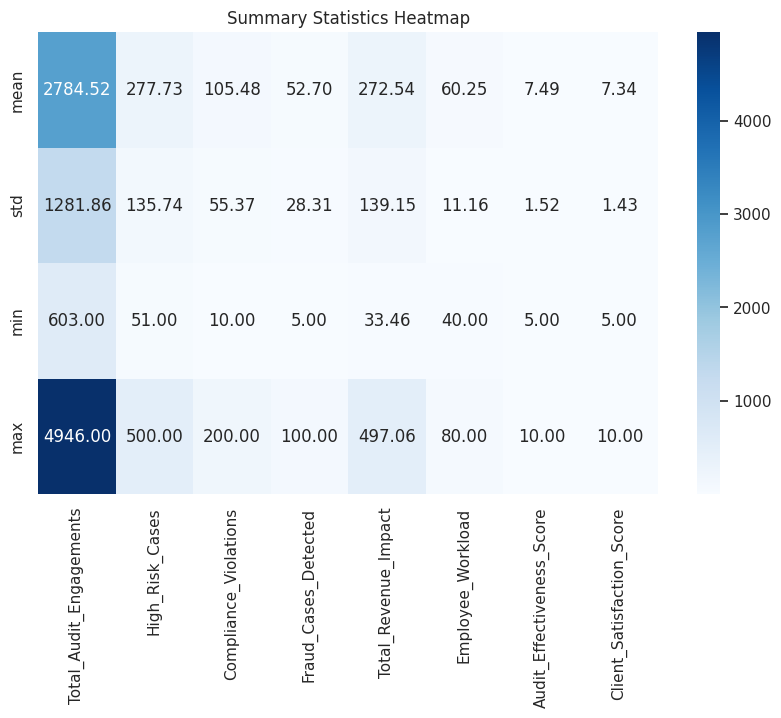

In [ ]:

numerical_cols = ['Total_Audit_Engagements', 'High_Risk_Cases', 'Compliance_Violations',
                  'Fraud_Cases_Detected', 'Total_Revenue_Impact','Employee_Workload',
                  'Audit_Effectiveness_Score', 'Client_Satisfaction_Score']
summary_stats = df_pd[numerical_cols].describe().loc[['mean', 'std', 'min', 'max']]

plt.figure(figsize=(10, 6))
sns.heatmap(summary_stats, annot=True, cmap='Blues', fmt=".2f")
plt.title('Summary Statistics Heatmap')
plt.show()



#Summary statistics analysis
The heatmap gives us a quick snapshot of the key metrics in our audit dataset. Here are a few takeaways:

Total Audit Engagements and Total Revenue Impact stand out with the largest numbers. On average, firms handled around 2,784 audits, but this varied a lot — some had as few as 600, while others exceeded 4,900. That’s a wide range, suggesting some firms manage a much higher audit volume than others.

High-Risk Cases, Compliance Violations, and Fraud Cases Detected have more moderate values but still show some variability. This hints at differences in how firms identify and handle risky or non-compliant audits.

The Audit Effectiveness Score and Client Satisfaction Score are on a 1–10 scale. Most scores are clustered around 7.3 to 7.5, which tells us that, generally, firms are performing fairly well and clients are reasonably satisfied — with little variation between them.

Employee Workload ranges from 40 to 80, averaging around 60. This might reflect staffing levels or how much work individual auditors handle.This variable could also be directly correclated to spefic firms that handle higher audit volumes.

Overall, this view helps us see where there is consistency across firms (like satisfaction scores) and where there is more variability (like audit volume and revenue impact). These differences could be useful later on when we explore relationships between AI usage, firm performance, and audit risk

#Visualizations using python library

#Boxplot for numerical values

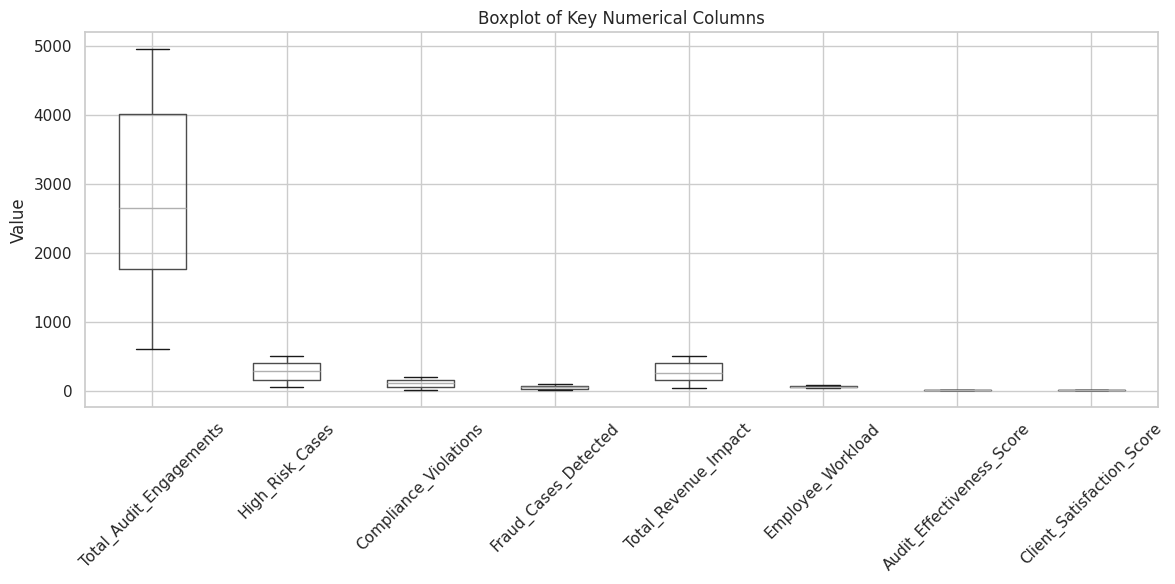

In [ ]:


plt.figure(figsize=(12, 6))
numerical_cols = ['Total_Audit_Engagements', 'High_Risk_Cases', 'Compliance_Violations',
                  'Fraud_Cases_Detected', 'Total_Revenue_Impact','Employee_Workload',
                  'Audit_Effectiveness_Score', 'Client_Satisfaction_Score']

df_pd[numerical_cols].boxplot()
plt.title('Boxplot of Key Numerical Columns')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.tight_layout()
plt.show()



This boxplot shows how different numerical audit metrics are distributed across the dataset. It's clear that there's a wide range in some features compared to others.

High variability is seen in Total_Audit_Engagements, High_Risk_Cases, and Total_Revenue_Impact, Their ranges are large, with total audit engament having the largest scale difference. These differences suggest that audit activity and associated risks can vary significantly between firms or years.

On the other hand, features like Audit_Effectiveness_Score, Client_Satisfaction_Score, and Fraud_Cases_Detected are more tightly grouped, showing more consistent values across the dataset.

In summary, this plot helps us see which variables might dominate unless scaled properly and which ones are already stable and uniform.


#Explore counts for categorical columns


In [ ]:
df_pd['Firm_Name'].value_counts()

,count
Firm_Name,
Deloitte,30
PwC,25
Ernst & Young,23
KPMG,22


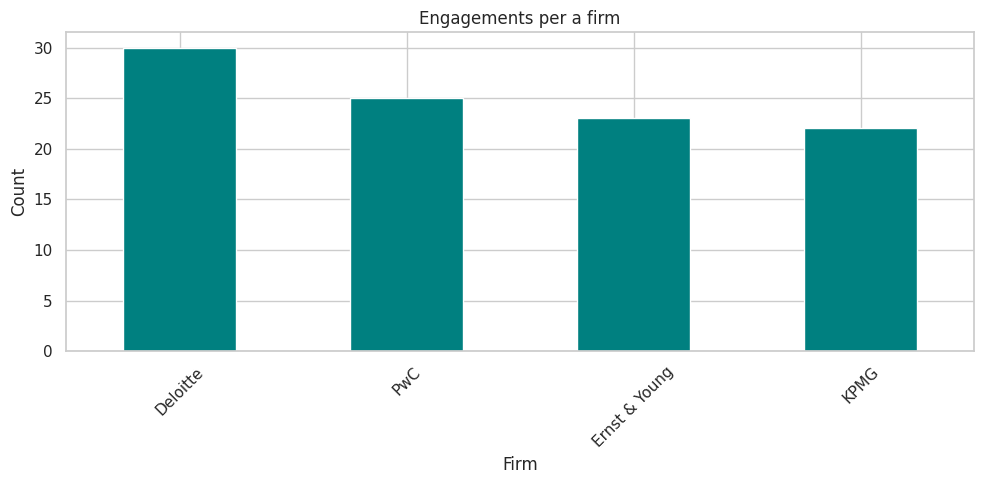

In [ ]:
plt.figure(figsize=(10, 5))
df_pd['Firm_Name'].value_counts().plot(kind='bar', color='teal')
plt.title('Engagements per a firm')
plt.xlabel('Firm')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Bar chart by firm

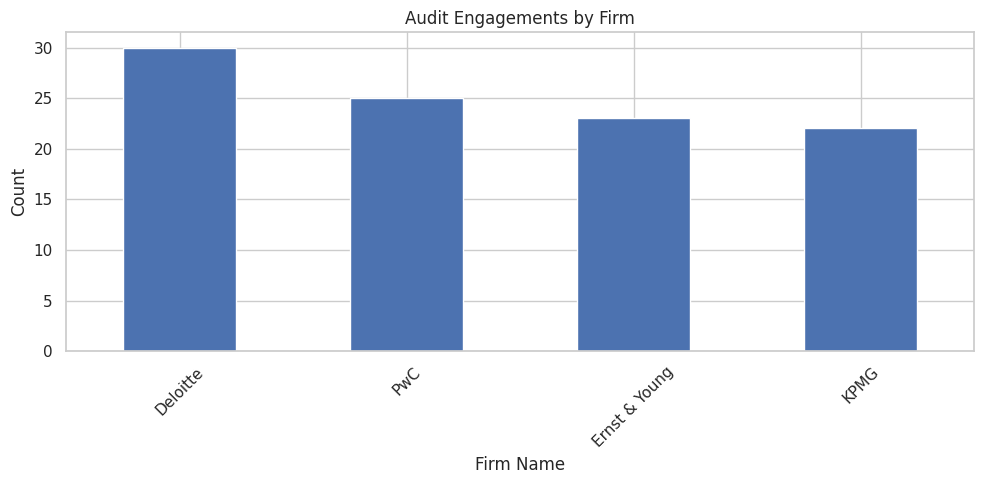

In [ ]:

# Firm name bar chart
plt.figure(figsize=(10, 5))
df_pd['Firm_Name'].value_counts().plot(kind='bar')
plt.title('Audit Engagements by Firm')
plt.xlabel('Firm Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





Audit Engagements by Firm: Deloitte appears to lead with the most audit engagements, followed closely by PwC, Ernst & Young, and KPMG. The relatively balanced distribution across firms suggests that all major firms are well represented in the data, though Deloitte may be slightly more active

In [ ]:
df_pd['Industry_Affected'].value_counts()


,count
Industry_Affected,
Tech,29
Retail,27
Healthcare,24
Finance,20


#Bar Chart by Industry

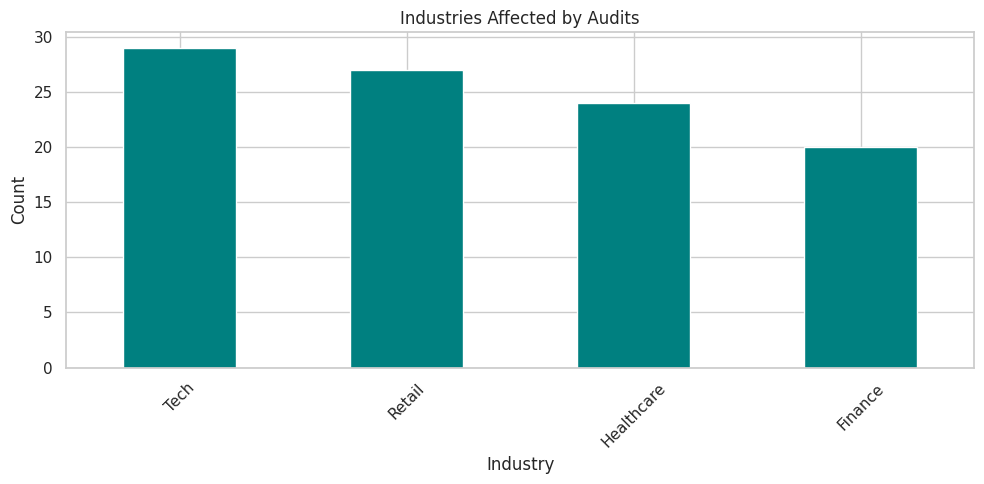

In [ ]:
# Industry bar chart
plt.figure(figsize=(10, 5))
df_pd['Industry_Affected'].value_counts().plot(kind='bar', color='teal')
plt.title('Industries Affected by Audits')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Industries Affected by Audits: The Tech and Retail sectors show the highest frequency of audits, followed by Healthcare and Finance. This may reflect regulatory sensitivity or audit demand in these sectors.

In [ ]:
df_pd['AI_Used_for_Auditing'].value_counts()


,count
AI_Used_for_Auditing,
No,55
Yes,45


#Pie Chart by AI Usage

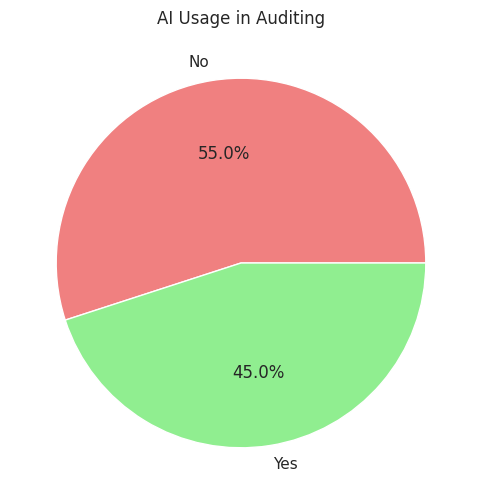

In [ ]:
# AI usage pie chart
plt.figure(figsize=(6, 6))
df_pd['AI_Used_for_Auditing'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('AI Usage in Auditing')
plt.ylabel('')
plt.show()




AI Usage in Auditing: 45% of the firms report using AI for auditing, while 55% do not. This fairly even split shows that AI adoption is growing but not yet the norm.

#Bar Chart: Total Fraud Cases by Firm

<ipython-input-18-1039458402>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


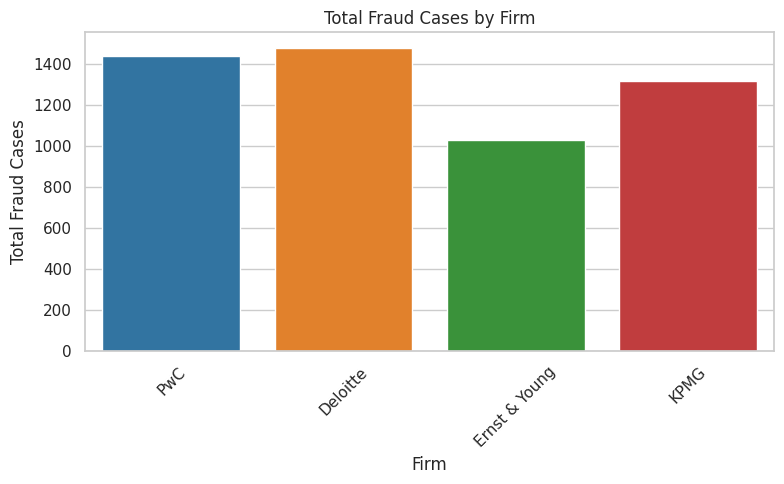

In [ ]:



# Updated color palette using full firm names from the dataset
firm_colors = {
    'PwC': '#1f77b4',               # blue
    'Deloitte': '#ff7f0e',          # orange
    'Ernst & Young': '#2ca02c',     # green
    'KPMG': '#d62728'               # red
}

# Use the dictionary directly in the palette argument
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_pd,
    x='Firm_Name',
    y='Fraud_Cases_Detected',
    estimator=np.sum,
    errorbar=None,
    palette=firm_colors
)
plt.title('Total Fraud Cases by Firm')
plt.xlabel('Firm')
plt.ylabel('Total Fraud Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This chart illustrates the total number of fraud cases identified by each firm:

Deloitte and PwC lead with the highest reported fraud cases, each exceeding 1,400. This may suggest either more extensive audit reach or greater detection capabilities.

KPMG also shows a strong presence, while Ernst & Young reports the fewest fraud cases among the four major firms.

#Bar Chart: Hish Risk Cases by Firm

<ipython-input-19-55032479>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


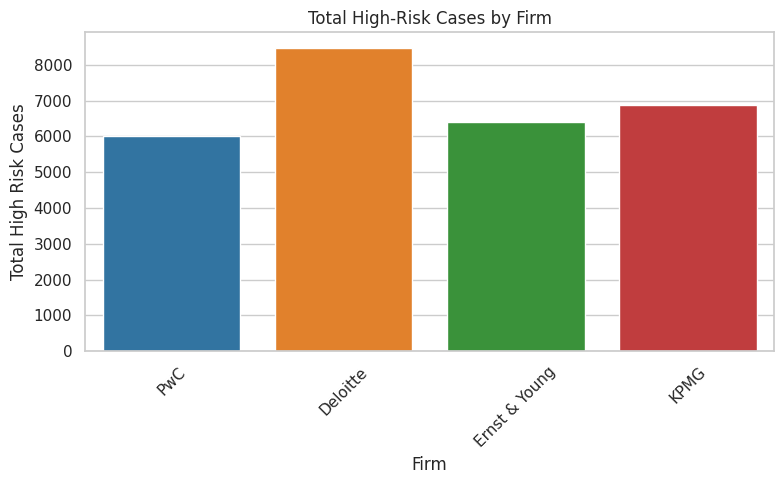

In [ ]:
# Updated color palette using full firm names from the dataset
firm_colors = {
    'PwC': '#1f77b4',               # blue
    'Deloitte': '#ff7f0e',          # orange
    'Ernst & Young': '#2ca02c',     # green
    'KPMG': '#d62728'               # red
}

# Use the dictionary directly in the palette argument
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_pd,
    x='Firm_Name',
    y='High_Risk_Cases',
    estimator=np.sum,
    errorbar=None,
    palette=firm_colors
)
plt.title('Total High-Risk Cases by Firm')
plt.xlabel('Firm')
plt.ylabel('Total High Risk Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar chart compares the total number of high-risk audit cases reported by each firm:

Deloitte has the highest number of high-risk cases, suggesting that their audit engagements may involve more complex or higher-stakes clients.

KPMG and Ernst & Young follow closely, with similar case volumes.

PwC reports the fewest high-risk cases among the four, though the difference isn’t extrem

#Correlation between high risk and fraud cases

In [ ]:
# Group totals by firm
risk_fraud_df = df_pd.groupby('Firm_Name')[['High_Risk_Cases', 'Fraud_Cases_Detected']].sum().reset_index()

# Now you can calculate the correlation
risk_fraud_df[['High_Risk_Cases', 'Fraud_Cases_Detected']].corr()

,High_Risk_Cases,Fraud_Cases_Detected
High_Risk_Cases,1.000000,0.444998
Fraud_Cases_Detected,0.444998,1.000000


The correlation coefficient between High-Risk Cases and Fraud Cases Detected is 0.44, indicating a moderate positive relationship. This supports the idea that high-risk audit flags can help predict fraud exposure.

#Line Chart fraud v high risk

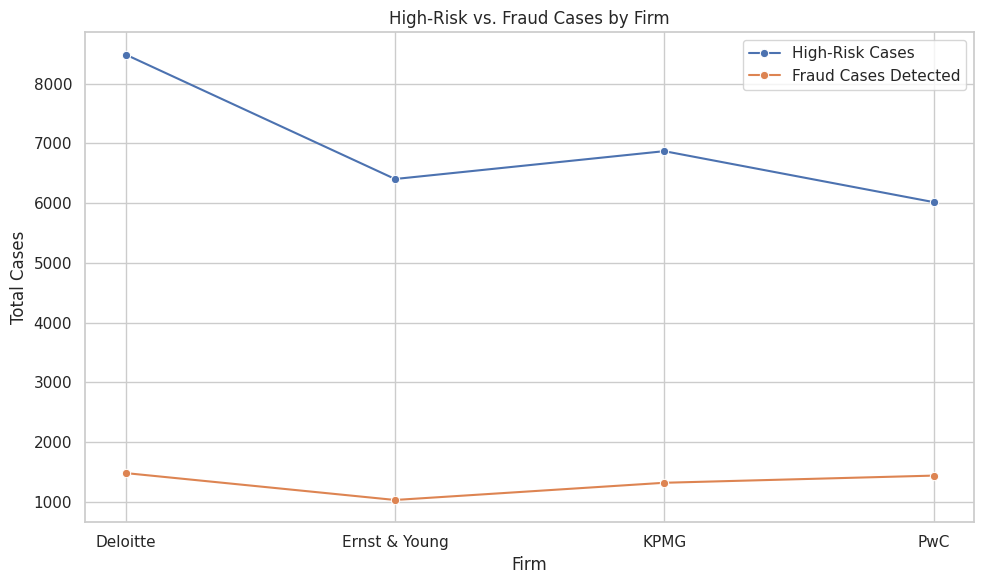

In [ ]:


# Group totals by firm
risk_fraud_df = df_pd.groupby('Firm_Name')[['High_Risk_Cases', 'Fraud_Cases_Detected']].sum().reset_index()

# Plot both lines on the same graph
plt.figure(figsize=(10, 6))
sns.lineplot(data=risk_fraud_df, x='Firm_Name', y='High_Risk_Cases', label='High-Risk Cases', marker='o')
sns.lineplot(data=risk_fraud_df, x='Firm_Name', y='Fraud_Cases_Detected', label='Fraud Cases Detected', marker='o')

plt.title('High-Risk vs. Fraud Cases by Firm')
plt.xlabel('Firm')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This line chart shows the total high-risk audit cases and fraud cases detected by each firm, helping visualize how early warning signs (high-risk audits) may relate to confirmed fraud findings.

Deloitte leads in both high-risk and fraud cases, suggesting that their early risk flags may be closely tied to actual fraud outcomes — possibly due to thorough follow-up or a higher-risk client base.

KPMG and PwC show similar patterns: moderate high-risk cases with consistent fraud detection.

Ernst & Young has lower values in both categories, indicating either more conservative risk flagging or a less fraud-prone portfolio.

While fraud cases remain much lower in absolute number than high-risk cases (as expected), the overall pattern suggests a positive directional relationship. In other words, firms that identify more high-risk cases also tend to detect more fraud.


#Line chart: high risk cases over time by industry

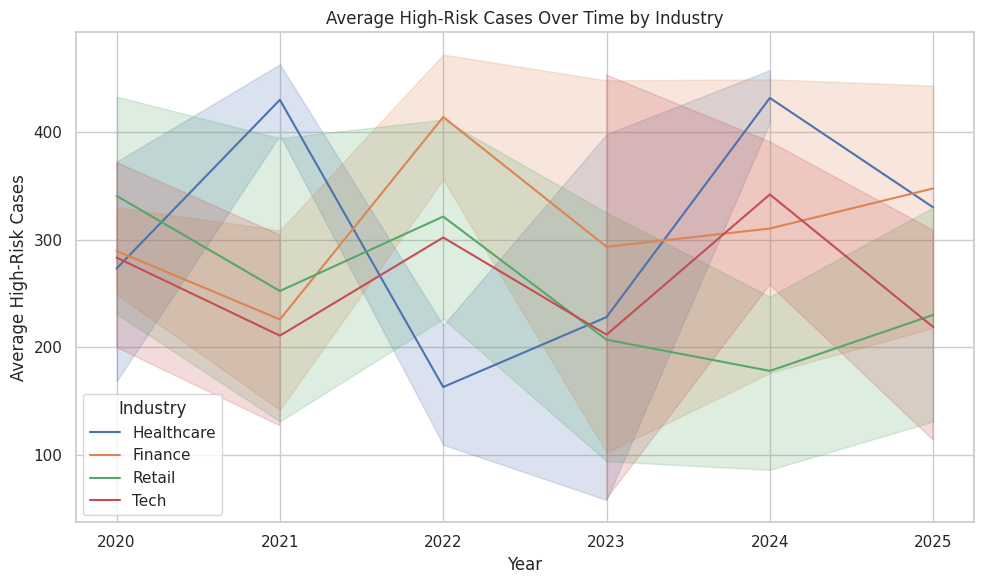

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pd, x='Year', y='High_Risk_Cases', hue='Industry_Affected', estimator='mean')
plt.title('Average High-Risk Cases Over Time by Industry')
plt.xlabel('Year')
plt.ylabel('Average High-Risk Cases')
plt.legend(title='Industry')
plt.tight_layout()
plt.show()

This plot shows how often audit engagements were flagged as high-risk.

Finance and Healthcare consistently show elevated high-risk activity, with noticeable peaks in 2021 and 2024.

Retail and Tech show more moderate or fluctuating patterns, with occasional dips.

#Line chart: fraud cases over time by industry

<ipython-input-23-2485117612>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


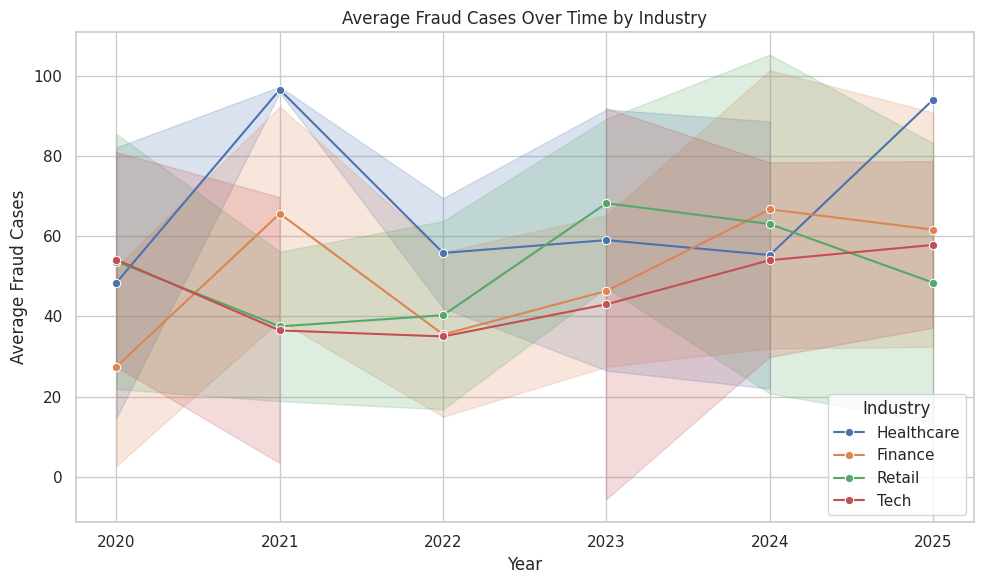

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_pd,
    x='Year',
    y='Fraud_Cases_Detected',
    hue='Industry_Affected',
    estimator='mean',
    ci='sd',
    marker='o'
)
plt.title('Average Fraud Cases Over Time by Industry')
plt.xlabel('Year')
plt.ylabel('Average Fraud Cases')
plt.legend(title='Industry')
plt.grid(True)
plt.tight_layout()
plt.show()


Fraud detection is naturally much lower in volume compared to high-risk flags.

Healthcare leads with the highest average fraud cases, especially in 2021 and 2025.

Tech and Finance show increasing trends toward 2025, possibly pointing to better detection or rising exposure.

#High risk cases led to fraud detection

In [ ]:
# Group and aggregate both values
agg_df = df_pd.groupby(['Year', 'Industry_Affected']).agg({
    'Fraud_Cases_Detected': 'sum',
    'High_Risk_Cases': 'sum'
}).reset_index()

# Add conversion rate
agg_df['Conversion_Rate'] = agg_df['Fraud_Cases_Detected'] / agg_df['High_Risk_Cases']


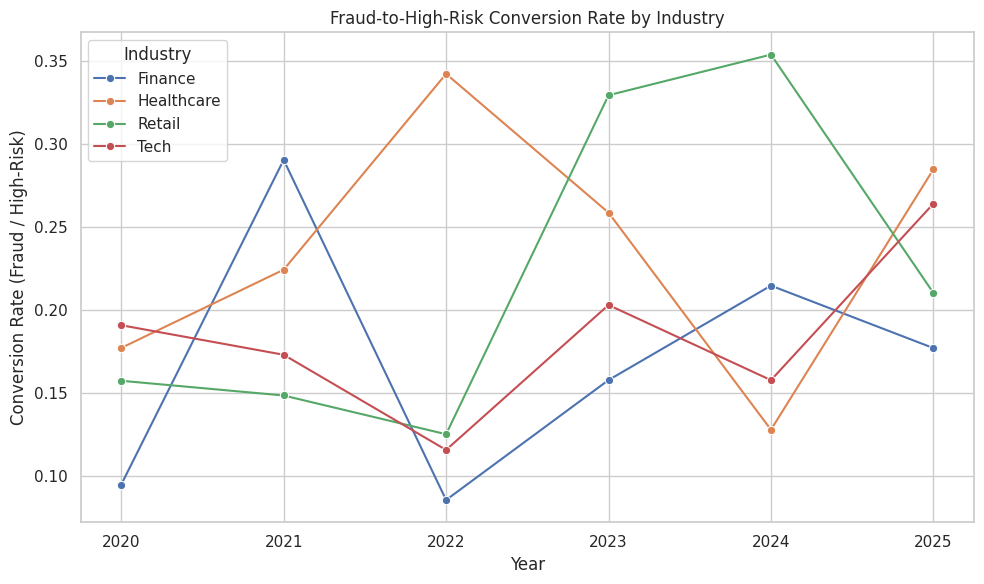

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_df,
    x='Year',
    y='Conversion_Rate',
    hue='Industry_Affected',
    marker='o'
)
plt.title('Fraud-to-High-Risk Conversion Rate by Industry')
plt.xlabel('Year')
plt.ylabel('Conversion Rate (Fraud / High-Risk)')
plt.legend(title='Industry')
plt.grid(True)
plt.tight_layout()
plt.show()


This KPI-style chart reveals how many high-risk audits actually led to fraud detection.

Retail showed a high conversion spike in 2023–2024, while Healthcare peaked in 2022.

Finance showed a high conversion spike in 2021 then id drop and peak gradually, which may suggest process optimization or stronger follow-through on risk flags.

Tech display more gradual and stable improvement in conversion, a slight increase in recent year 2024 and 2025

#Box Plot: Audit Effectiveness Score vs. AI Usage

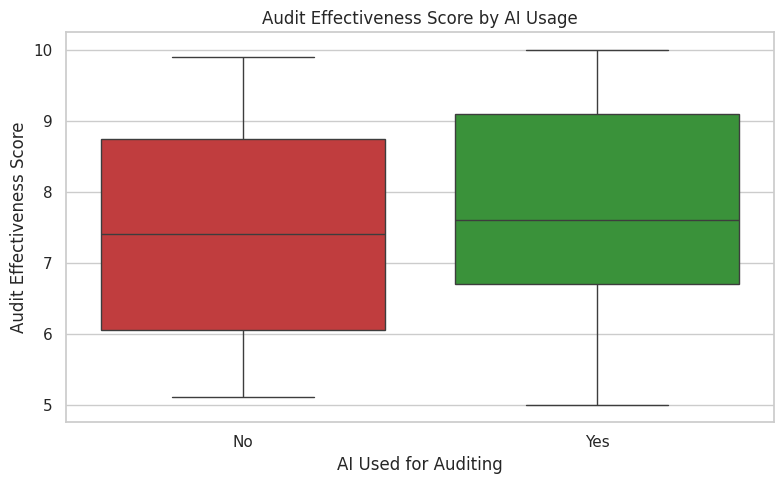

In [ ]:


# Normalize case of the category
df_pd['AI_Used_for_Auditing'] = df_pd['AI_Used_for_Auditing'].str.title()

# Define palette with title-case keys
ai_palette = {
    'Yes': '#2ca02c',  # green
    'No': '#d62728'    # red
}

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_pd,
    x='AI_Used_for_Auditing',
    y='Audit_Effectiveness_Score',
    hue='AI_Used_for_Auditing',
    palette=ai_palette,
    legend=False
)
plt.title('Audit Effectiveness Score by AI Usage')
plt.xlabel('AI Used for Auditing')
plt.ylabel('Audit Effectiveness Score')
plt.tight_layout()
plt.show()


This boxplot compares the distribution of audit effectiveness scores between firms that use AI for auditing and those that don’t:

Median scores (the horizontal lines in each box) are slightly higher for firms that use AI, suggesting a modest boost in effectiveness.

Firms using AI also have a higher upper quartile and maximum scores, indicating that they’re more likely to achieve top-tier effectiveness.

Both groups show some variability, but the spread is slightly wider among AI-using firms — possibly reflecting different levels of AI maturity or integration.

While not dramatic, the results suggest that AI usage is associated with higher audit effectiveness on average. This supports the idea that AI tools may enhance audit precision, coverage, or risk detection when implemented well.

#Line chart : Average effectiveness Score over time by AI usage

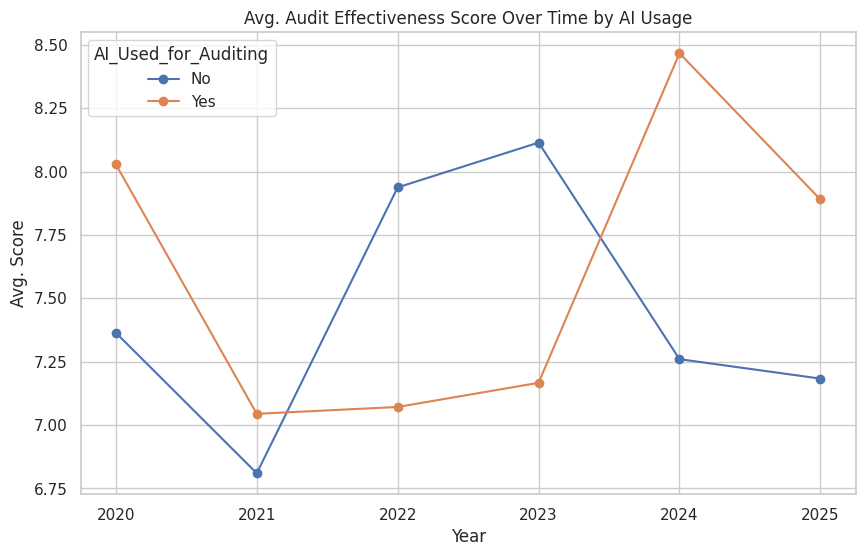

In [ ]:
df_pd.groupby(['Year', 'AI_Used_for_Auditing'])['Audit_Effectiveness_Score'].mean().unstack().plot(
    kind='line', marker='o', figsize=(10,6)
)
plt.title("Avg. Audit Effectiveness Score Over Time by AI Usage")
plt.ylabel("Avg. Score")
plt.xlabel("Year")
plt.grid(True)
plt.show()


The first chart shows how average audit effectiveness scores changed over time for firms that used AI versus those that did not:

From 2020 to a little after 2021 firms using AI had a higher effectiveness average score.

From 2021 to 2023, firms not using AI generally showed higher average effectiveness. Showing a decline with firms using AI.

However, starting in 2024, firms using AI experienced a noticeable jump in effectiveness, surpassing their non-AI counterparts.

This trend suggests that while early AI adoption may not have yielded immediate benefits, recent years show a strong payoff, potentially due to improved tools or more integrated AI processes.

#Line charts: Audit effectiveness score by firm  and by AI usage

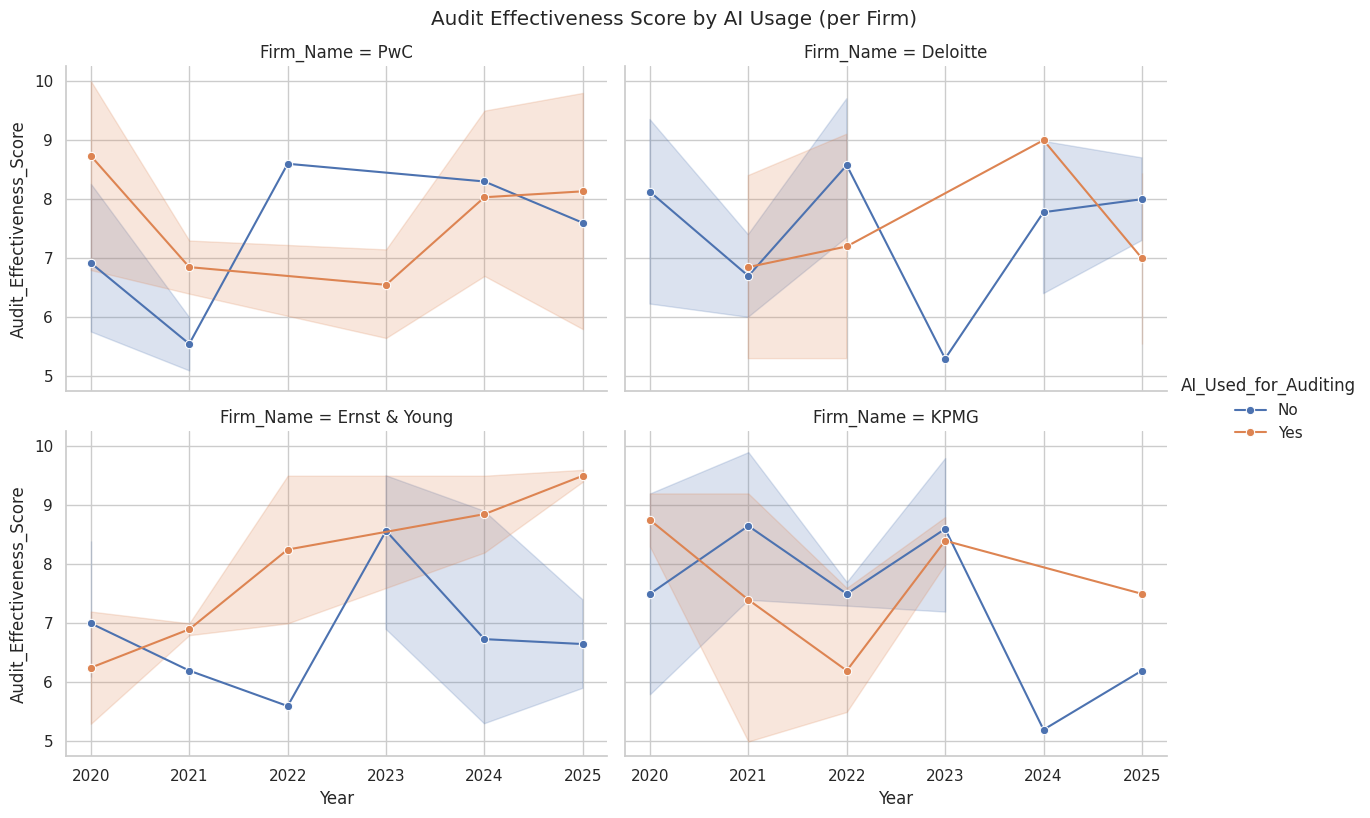

In [ ]:
g = sns.FacetGrid(
    df_pd,
    col="Firm_Name",
    hue="AI_Used_for_Auditing",
    col_wrap=2,
    height=4,
    aspect=1.5
)
g.map(sns.lineplot, "Year", "Audit_Effectiveness_Score", marker="o").add_legend()
g.fig.suptitle("Audit Effectiveness Score by AI Usage (per Firm)", y=1.02)
plt.show()


Breaks down the same metric audit effectiveness over time by individual firm (PwC, Deloitte, Ernst & Young, KPMG):

Ernst & Young and PwC show the most consistent improvement in effectiveness when AI is used, especially in later years.

Deloitte and KPMG show more variation — with some years where AI and non-AI performance are close, or AI appears to lag.

This variation suggests that the impact of AI on audit effectiveness depends not just on adoption, but on how well it's implemented and integrated into firm practice

#Box Plot employee workload by AI usage

<ipython-input-29-3431711757>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pd, x='AI_Used_for_Auditing', y='Employee_Workload', palette='Set2')


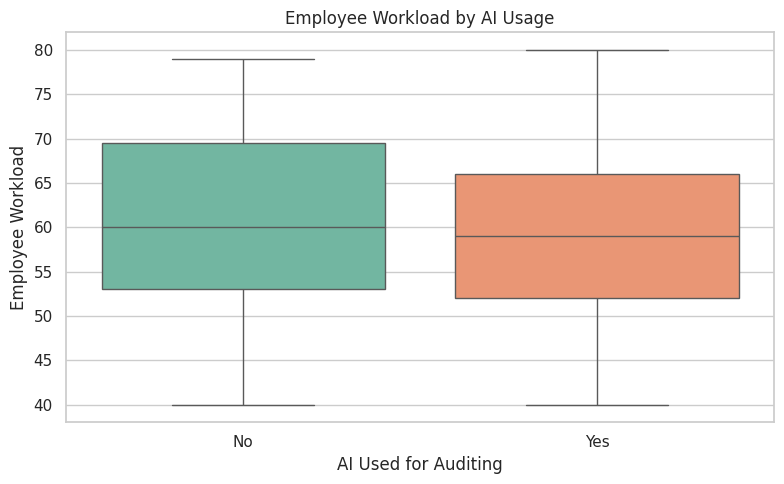

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_pd, x='AI_Used_for_Auditing', y='Employee_Workload', palette='Set2')
plt.title("Employee Workload by AI Usage")
plt.xlabel("AI Used for Auditing")
plt.ylabel("Employee Workload")
plt.tight_layout()
plt.show()


This boxplot compares employee workload between firms that used AI for auditing and those that did not:

On average, firms using AI show a slightly lower median workload compared to those not using AI.

The interquartile range (middle 50% of values) is right in the middle for AI-using firms, suggesting more consistency in workload distribution.



#Average employee workload over time

<ipython-input-30-1434904953>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_pd, x='Year', y='Employee_Workload', estimator='mean', ci='sd', marker='o')


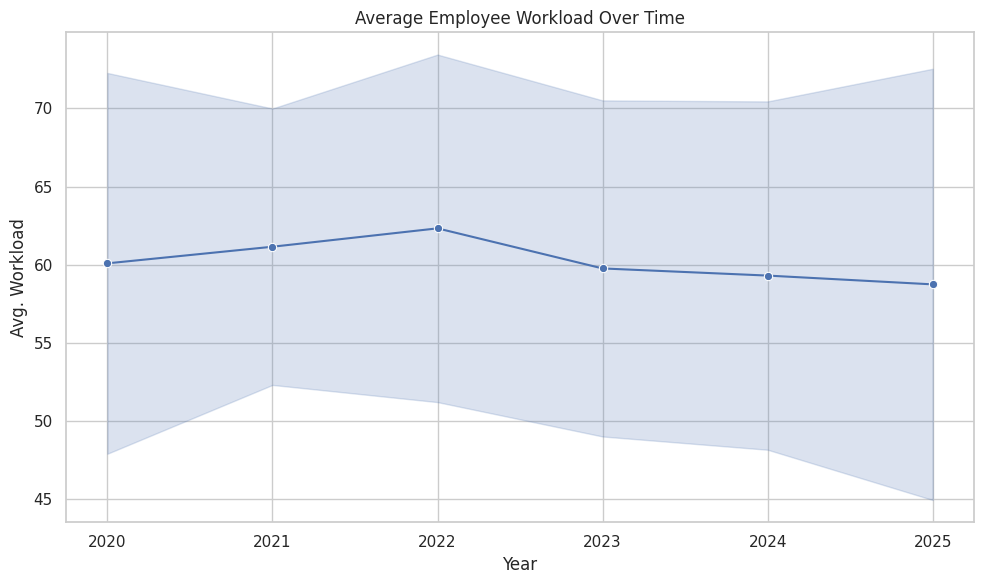

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pd, x='Year', y='Employee_Workload', estimator='mean', ci='sd', marker='o')
plt.title("Average Employee Workload Over Time")
plt.ylabel("Avg. Workload")
plt.grid(True)
plt.tight_layout()
plt.show()


The dip in workload after 2022 may reflect the impact of AI adoption, process improvements, or shifts in audit strategy. While the change isn’t dramatic, the downward trend suggests that employees may be benefiting from more efficient systems, reducing time spent per engagement.

#Average employee workload by firm and AI usage

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/

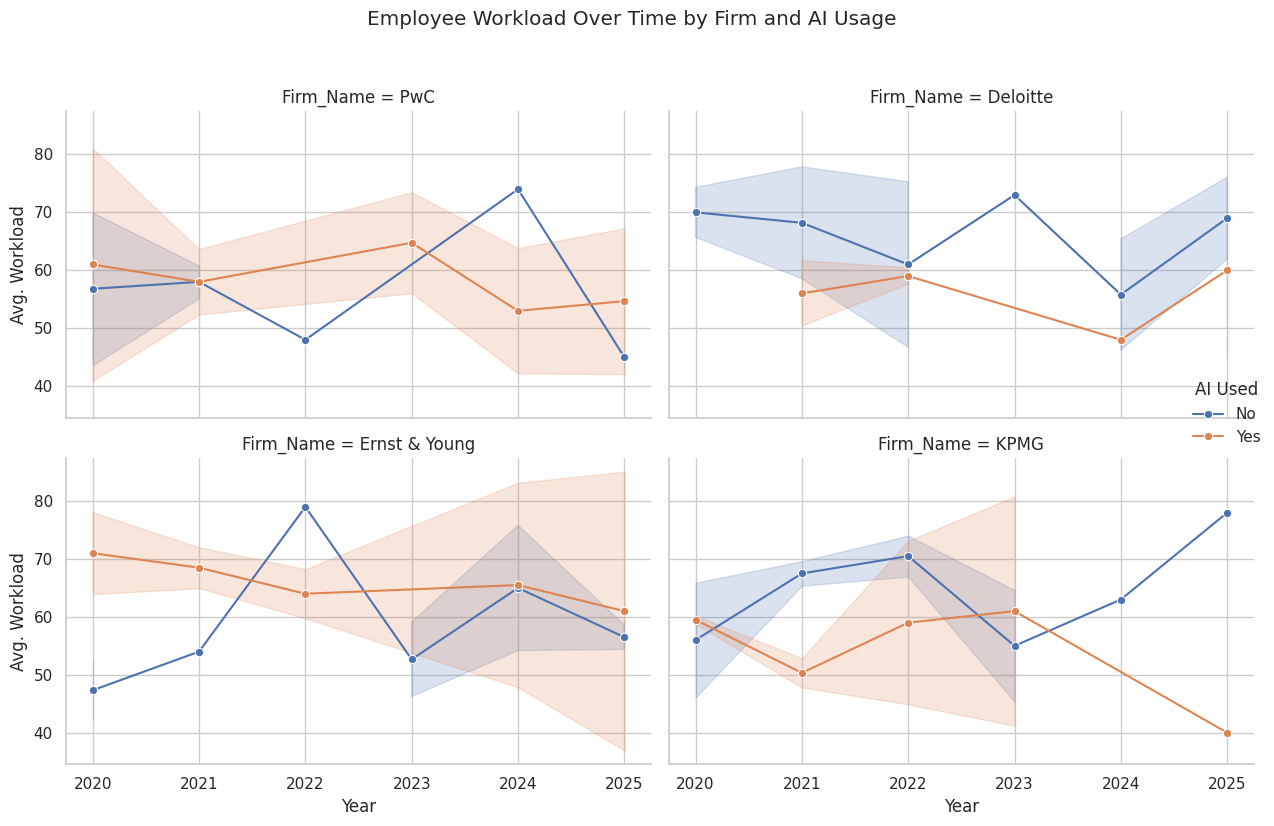

In [ ]:


# Create separate line plots for each firm
g = sns.FacetGrid(
    df_pd,
    col="Firm_Name",
    hue="AI_Used_for_Auditing",
    col_wrap=2,           # 2 charts per row; you can increase to 4 if preferred
    height=4,
    aspect=1.5,
    sharey=True           # Keep the same y-axis scale across charts for comparison
)

g.map(
    sns.lineplot,
    "Year",
    "Employee_Workload",
    marker="o",
    estimator="mean",
    ci="sd"
)

# Add title and legend
g.add_legend(title="AI Used")
g.set_axis_labels("Year", "Avg. Workload")
g.fig.suptitle("Employee Workload Over Time by Firm and AI Usage", y=1.03)
plt.tight_layout()
plt.show()


PwC shows a relatively stable workload trend, with AI audits often resulting in slightly lower or equal workload compared to non-AI audits — especially in 2024 and 2025.

Deloitte consistently shows higher workload for non-AI audits, with AI usage helping reduce workload across most years. The contrast is particularly visible from 2022 onward.

Ernst & Young has fluctuating trends, but AI audits generally show a lower and more stable workload than non-AI ones, which spike sharply in 2022.

KPMG reveals the most dramatic benefit: AI audits show a sharp decline in workload over time, while non-AI audits rise steadily, peaking in 2025.

While patterns vary by firm, a common theme is that AI usage tends to reduce or stabilize employee workload, especially in firms like KPMG and Deloitte. This suggests that firms leveraging AI effectively may be better positioned to reduce auditor strain and improve operational efficiency over time.

#Boxplot revuew impact by AI usage

<ipython-input-32-3898588148>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


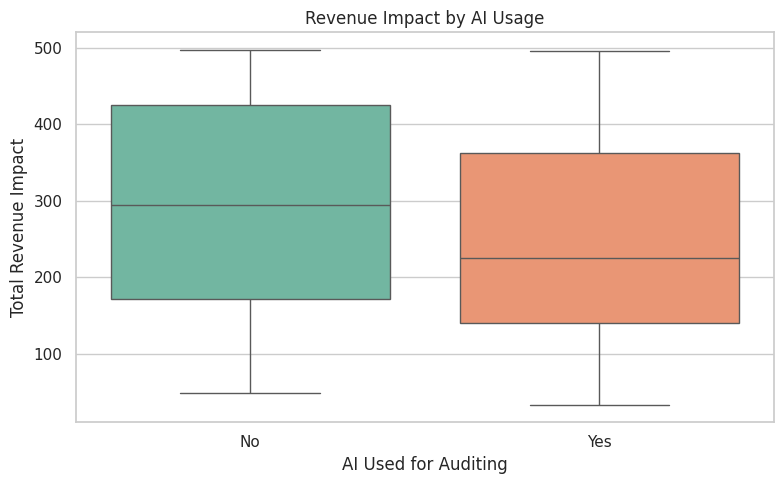

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_pd,
    x='AI_Used_for_Auditing',
    y='Total_Revenue_Impact',
    palette='Set2'
)
plt.title("Revenue Impact by AI Usage")
plt.ylabel("Total Revenue Impact")
plt.xlabel("AI Used for Auditing")
plt.tight_layout()
plt.show()


Lower median impact with AI: The median revenue impact is noticeably lower when AI was used, suggesting that AI-assisted audits are generally associated with reduced financial exposure.

Tighter distribution: The interquartile range (middle 50%) is narrower for AI usage, indicating more consistent results and fewer extreme revenue losses.

Wider spread without AI: Non-AI audits show a broader range and more extreme high values, implying that revenue risk is more volatile without AI.

AI usage appears to reduce not only the average revenue impact but also the variability of outcomes, helping firms control audit costs and mitigate financial risk by using tools to flags issues early which then can  auditors correct resulting in no penalty or loss.

#Boxplot : Revenue impact by industry

<ipython-input-33-1656262044>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


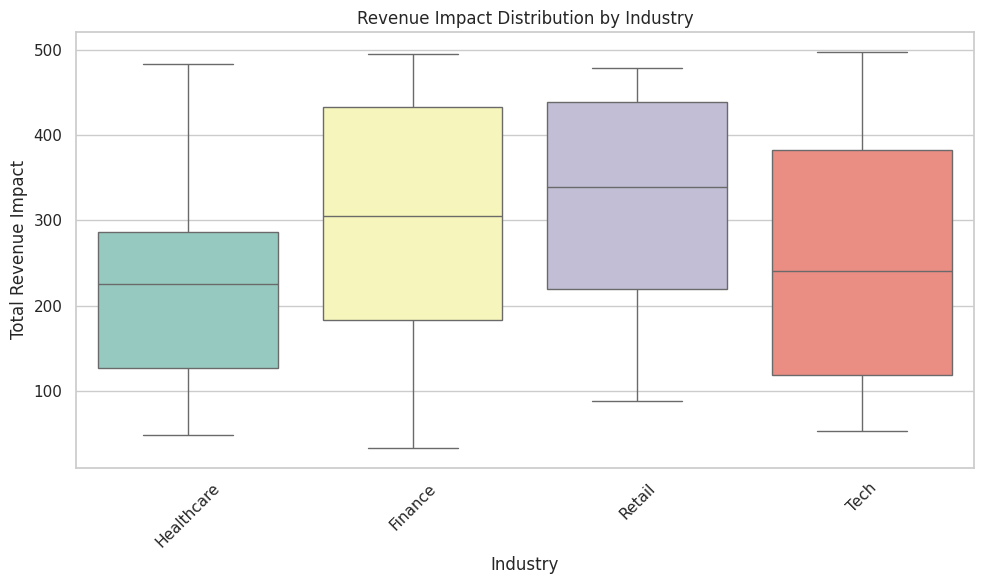

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_pd,
    x='Industry_Affected',
    y='Total_Revenue_Impact',
    palette='Set3'
)
plt.title("Revenue Impact Distribution by Industry")
plt.ylabel("Total Revenue Impact")
plt.xlabel("Industry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This boxplot illustrates how total revenue impact varies across industries:

Retail and Finance industries exhibit the widest spread in revenue impact, suggesting a high degree of variability. These sectors have both high-performing and underperforming cases, possibly due to varying firm sizes or audit complexities.

Tech shows a relatively high upper quartile, with some extreme high-impact values, but also a lower median, pointing to inconsistent results across audits.

Healthcare appears to have the lowest variability and a more consistent distribution, though its median revenue impact is also lower than other sectors.

Overall, while Retail and Finance offer potential for high revenue recovery or loss prevention, they also come with greater uncertainty. In contrast, Healthcare shows more stability, though possibly with less upside.

#Line chart : Revenue impact over time

<ipython-input-34-4193258082>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


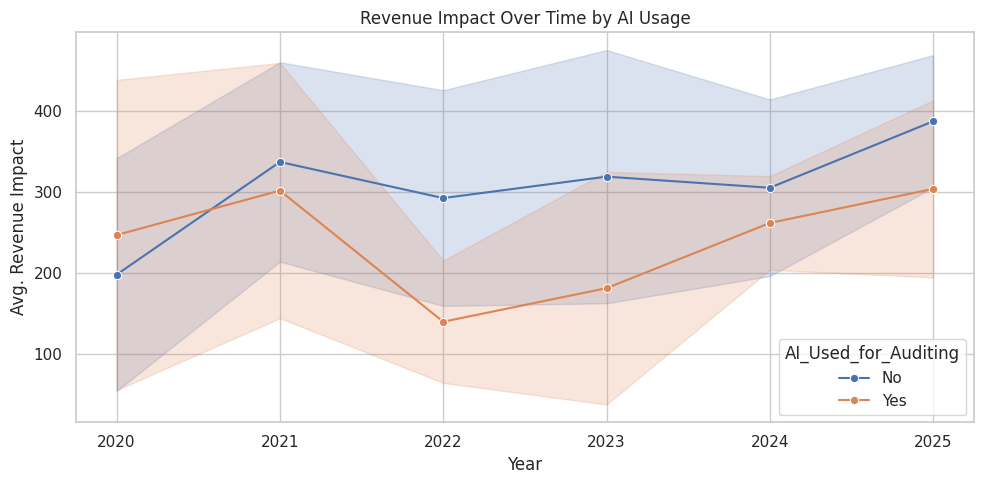

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_pd,
    x='Year',
    y='Total_Revenue_Impact',
    hue='AI_Used_for_Auditing',
    estimator='mean',
    ci='sd',
    marker='o'
)
plt.title("Revenue Impact Over Time by AI Usage")
plt.ylabel("Avg. Revenue Impact")
plt.grid(True)
plt.tight_layout()
plt.show()


This line plot shows how the average revenue impact has changed from 2020 to 2025, comparing audits with and without AI usage.

Consistently Lower Revenue Impact with AI: Across all years, audits using AI show lower average revenue impact compared to those without AI.

2022 - 2023 Drop with AI: Revenue impact dropped significantly in 2022 and remained lower through 2023 for AI-assisted audits, suggesting improved loss prevention during those years.

By 2025, the average revenue impact for AI audits nearly matches that of non-AI, reducing the earlier performance advantage. Possible due to AI tools not evolving fast enough to catch newer types of audit risk or fraud.

#Line charts : Revenue impact over time by industry

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/

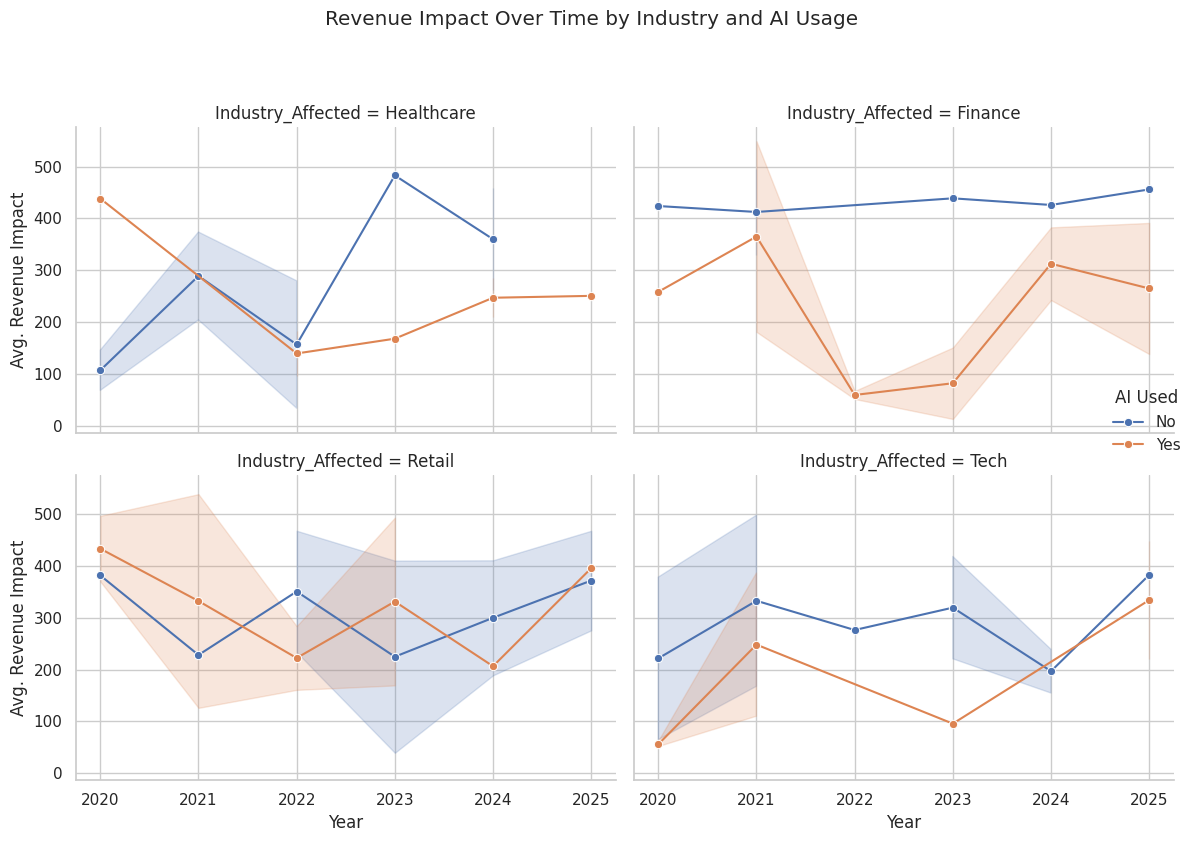

In [ ]:
g = sns.FacetGrid(
    df_pd,
    col="Industry_Affected",
    hue="AI_Used_for_Auditing",
    col_wrap=2,
    height=4,
    aspect=1.4,
    sharey=True
)
g.map(
    sns.lineplot,
    'Year',
    'Total_Revenue_Impact',
    estimator='mean',
    ci='sd',
    marker='o'
)
g.add_legend(title="AI Used")
g.set_axis_labels("Year", "Avg. Revenue Impact")
g.fig.suptitle("Revenue Impact Over Time by Industry and AI Usage", y=1.05)
plt.tight_layout()
plt.show()


his multi-panel line chart shows how average revenue impact varies over time by industry and AI adoption:

Healthcare: Revenue impact from non-AI audits surged in 2023 and 2024. AI usage shows more stable but consistently lower revenue impact, suggesting AI may help contain financial losses.

Finance: Non-AI audits have a higher and more stable revenue impact across all years. However, AI usage shows large fluctuations, especially a sharp dip in 2022–2023, indicating potential instability or inconsistent adoption benefits in this sector.

Retail: Both AI and non-AI revenue impacts fluctuate. AI usage initially performed better (2020), dipped mid-period, and caught up by 2025 , suggesting a closing performance gap between AI and non-AI.

Tech: Revenue impact was higher without AI across most years. However, AI-based audits began catching up by 2025 ,possibly reflecting gradual maturity in AI adoption within the tech sector.

While AI audits generally show lower revenue impact early on, most industries show improvement by 2025, indicating AI’s growing role in reducing revenue loss or managing risk over time. The performance gap between AI and non-AI is narrowing, especially in Retail and Tech.

#Correlations

#Scatterplot : Workload vs audit effectiveness

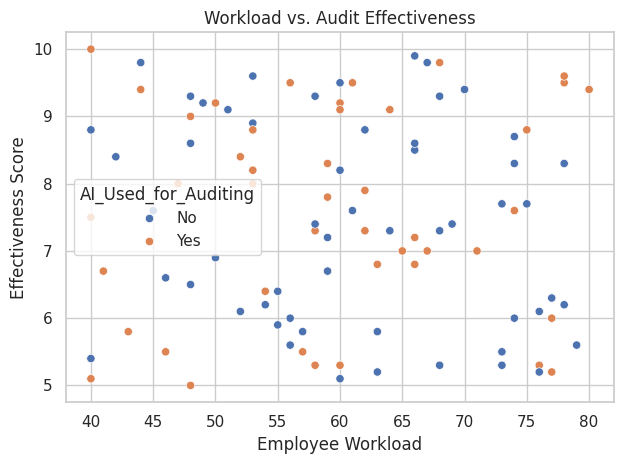

In [ ]:
sns.scatterplot(data=df_pd, x='Employee_Workload', y='Audit_Effectiveness_Score', hue='AI_Used_for_Auditing')
plt.title("Workload vs. Audit Effectiveness")
plt.xlabel("Employee Workload")
plt.ylabel("Effectiveness Score")
plt.grid(True)
plt.tight_layout()
plt.show()


No Strong Correlation: The points are widely scattered without a clear upward or downward trend, indicating no strong linear relationship between employee workload and audit effectiveness.

In [ ]:
correlation = df_spark.select(corr("Total_Revenue_Impact", "Compliance_Violations")).collect()[0][0]
print(f"Correlation between Total_Revenue_Impact and Compliance_Violations: {correlation}")

Correlation between Total_Revenue_Impact and Compliance_Violations: 0.11291409942446395


Correlation Coefficient: 0.1129
This indicates a very weak positive correlation, suggesting that as revenue impact increases, compliance violations may slightly increase — but the relationship is not strong or reliable.

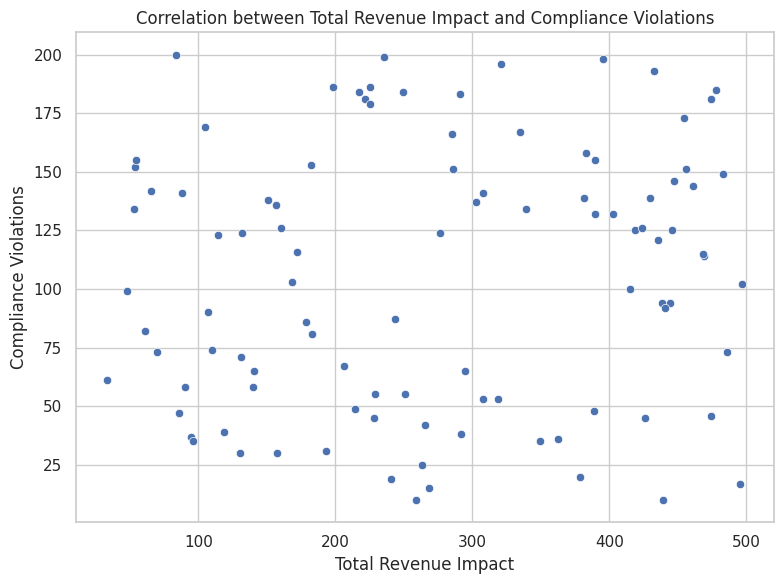

In [ ]:


plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(data=df_pd, x='Total_Revenue_Impact', y='Compliance_Violations')
plt.title('Correlation between Total Revenue Impact and Compliance Violations')
plt.xlabel('Total Revenue Impact')
plt.ylabel('Compliance Violations')
plt.tight_layout()
plt.show()

This scatterplot and correlation score illustrate the relationship between Total Revenue Impact and Compliance Violations.

The points are broadly dispersed without a clear linear trend.

Violations span the full range of revenue impact levels, with no dominant concentration pattern.



#Correlation heatmap

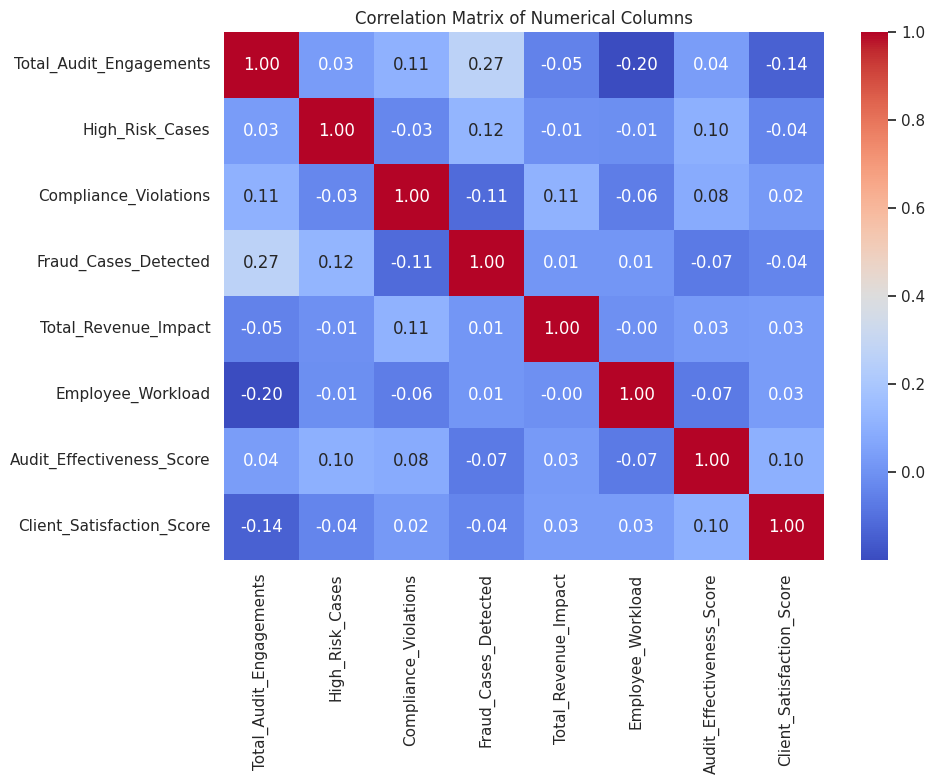

In [ ]:
correlation_matrix = df_pd[numerical_cols].corr()
# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.tight_layout()
plt.show()

1.Fraud Cases Detected
Positively correlated with:

Total_Audit_Engagements (r = 0.27): More audits are linked to more detected fraud — expected, as increased scrutiny reveals more issues.

High_Risk_Cases (r = 0.12): Slight alignment, suggesting high-risk cases sometimes lead to fraud discovery.

Negatively correlated with:

Audit_Effectiveness_Score (r = -0.07): May suggest a trade-off—audits detecting fraud might uncover poor practices, not necessarily drive up effectiveness.

2.Compliance Violations
Weak correlations across the board:

Slight positive link with Total_Audit_Engagements (r = 0.11) and Total_Revenue_Impact (r = 0.11).

This may indicate audits uncover violations, but not strong enough to infer causality or financial impact.

3.Total Revenue Impact
Weak correlations overall:

Small positive correlation with Compliance_Violations (r = 0.11) and Fraud_Cases_Detected (r = 0.01).

4 Employee Workload
Negatively correlated with:

Audit_Effectiveness_Score (r = -0.07): Implies high workload might slightly reduce audit effectiveness.

5.Client Satisfaction
(r= -0.14): Has a negative correlation with total audit engaments. As audits increase the client satifaction decreases.

(r = 0.10) Has a positive correlation with audit effectiveness. As audit effectiveness increases so does client satisfaction.



#Can AI adoption reduce fraud and improve compliance in Big 4 firms?

In [ ]:
# Register the DataFrame as a SQL view
df_spark.createOrReplaceTempView("big4_audit")


In [ ]:
spark.sql("""
SELECT
  AI_Used_for_Auditing,
  SUM(Fraud_Cases_Detected) AS total_fraud_cases,
  SUM(Compliance_Violations) AS total_compliance_violations
FROM big4_audit
GROUP BY AI_Used_for_Auditing
""").show()



+--------------------+-----------------+---------------------------+
|AI_Used_for_Auditing|total_fraud_cases|total_compliance_violations|
+--------------------+-----------------+---------------------------+
|                  No|             3010|                       6122|
|                 Yes|             2260|                       4426|
+--------------------+-----------------+---------------------------+



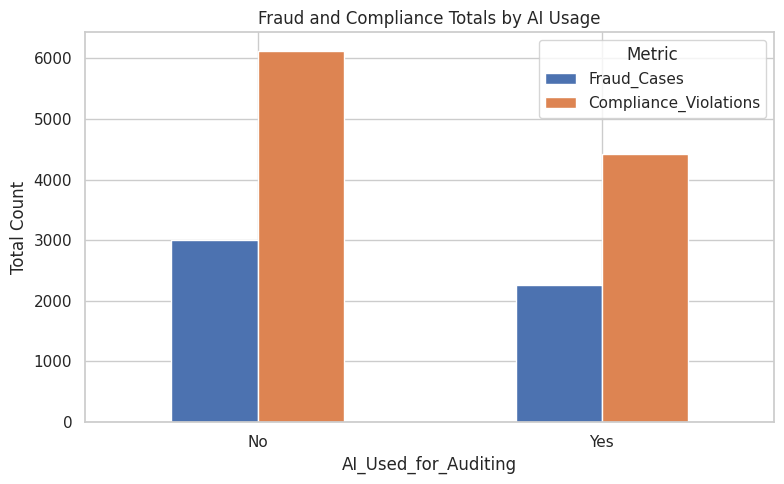

In [ ]:

# Manually create a DataFrame from  Spark SQL output
data = {
    'AI_Used_for_Auditing': ['No', 'Yes'],
    'Fraud_Cases': [3010, 2260],
    'Compliance_Violations': [6122, 4426]
}

df_vis = pd.DataFrame(data)

# Plot
df_vis.set_index('AI_Used_for_Auditing').plot(kind='bar', figsize=(8, 5))
plt.title("Fraud and Compliance Totals by AI Usage")
plt.ylabel("Total Count")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


<ipython-input-43-2609946340>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


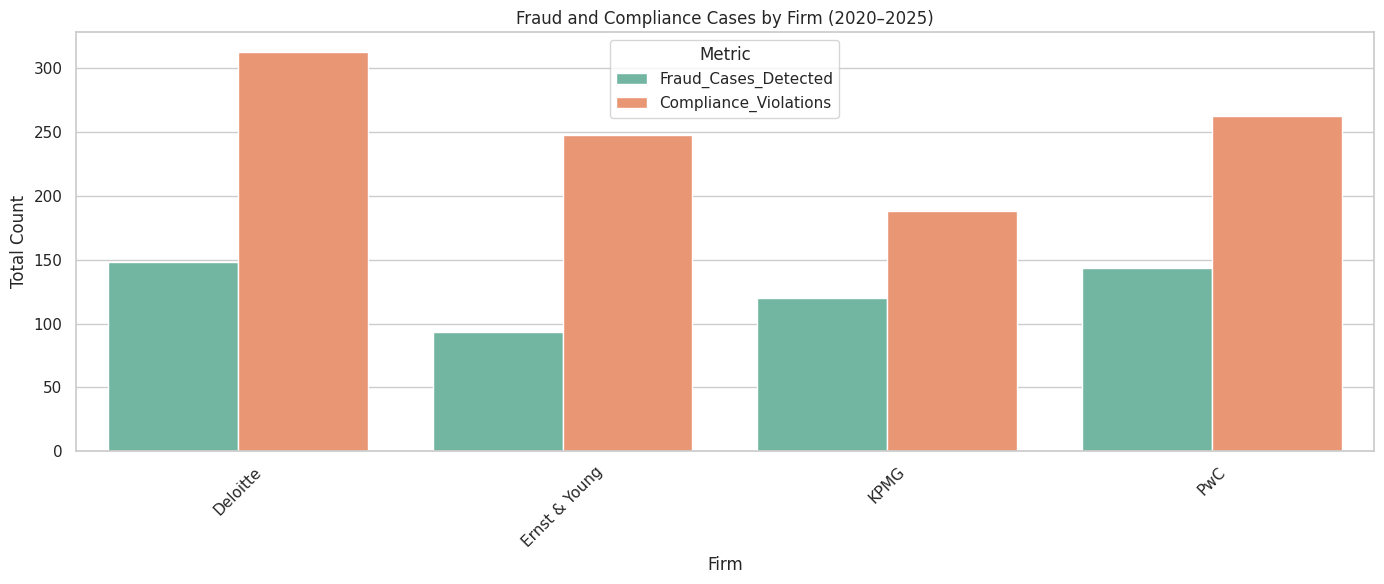

In [ ]:
# Group both fraud and compliance metrics
grouped = df_pd.groupby(['Year', 'Firm_Name', 'AI_Used_for_Auditing']).agg({
    'Fraud_Cases_Detected': 'sum',
    'Compliance_Violations': 'sum'
}).reset_index()

# Melt the DataFrame into long format for seaborn
melted = grouped.melt(
    id_vars=['Year', 'Firm_Name', 'AI_Used_for_Auditing'],
    value_vars=['Fraud_Cases_Detected', 'Compliance_Violations'],
    var_name='Metric',
    value_name='Total_Count'
)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=melted,
    x='Firm_Name',
    y='Total_Count',
    hue='Metric',
    palette='Set2',
    ci=None
)
plt.title('Fraud and Compliance Cases by Firm (2020–2025)')
plt.xlabel('Firm')
plt.ylabel('Total Count')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

spark.sql("""
SELECT
  AI_Used_for_Auditing,
  COUNT(*) AS total_records,
  SUM(Fraud_Cases_Detected) AS total_fraud_cases,
  SUM(Compliance_Violations) AS total_compliance_violations,
  ROUND(SUM(Fraud_Cases_Detected) * 1.0 / SUM(Total_Audit_Engagements), 4) AS fraud_per_engagement,
  ROUND(SUM(Compliance_Violations) * 1.0 / SUM(Total_Audit_Engagements), 4) AS compliance_per_engagement
FROM big4_audit
GROUP BY AI_Used_for_Auditing
""").show()

+--------------------+-------------+-----------------+---------------------------+--------------------+-------------------------+
|AI_Used_for_Auditing|total_records|total_fraud_cases|total_compliance_violations|fraud_per_engagement|compliance_per_engagement|
+--------------------+-------------+-----------------+---------------------------+--------------------+-------------------------+
|                  No|           55|             3010|                       6122|              0.0197|                   0.0401|
|                 Yes|           45|             2260|                       4426|              0.0179|                   0.0352|
+--------------------+-------------+-----------------+---------------------------+--------------------+-------------------------+



### Insight: Can AI adoption reduce fraud and improve compliance in Big 4 firms?

The data suggests that AI adoption is associated with improved compliance outcomes and reduced fraud cases across Big 4 audit firms.

Aggregate Comparison:

Firms without AI reported 3,010 fraud cases and 6,122 compliance violations.

Firms with AI reported 2,260 fraud cases and 4,426 compliance violations.

This reflects a 25% reduction in fraud and a 28% reduction in compliance violations when AI was used.

Normalized Performance (per audit engagement):

Fraud per engagement dropped from 0.0197 to 0.0179 (approx. 9% improvement).

Compliance violations per engagement dropped from 0.0401 to 0.0352 (approx. 12% improvement).

Firm-Level Trends:

Deloitte and Ernst & Young showed clear declines in both fraud and compliance violations after adopting AI.

KPMG and PwC, however, displayed smaller or inconsistent gains, suggesting variation in how effectively AI was implemented across firms.

The results suggest that using AI in auditing can help firms catch fraud earlier and improve compliance. Firms that adopted AI tools tended to have fewer fraud cases and lower rates of compliance violations per audit compared to those that didn't use AI.

This doesn;t mean AI eliminates problems completely, but when used consistently and effectively, it seems to help teams stay on top of issues before they grow. It supports auditors by automating routine checks, spotting red flags faster, and helping ensure that audits follow the rules more closely.

In short, AI adoption appears to strengthen both fraud detection and compliance, especially when it's thoughtfully integrated into day-to-day audit work


#Which firm managed to maintain the best compliance performance despite a high workload?

In [ ]:
spark.sql("""
SELECT
    Firm_Name,
    ROUND(AVG(Employee_Workload), 1) AS avg_workload,
    ROUND(AVG(Compliance_Violations), 1) AS avg_compliance_violations,
    ROUND(AVG(High_Risk_Cases), 1) AS avg_high_risk_cases
FROM big4_audit
WHERE Employee_Workload >= (
    SELECT PERCENTILE(Employee_Workload, 0.75) FROM big4_audit
)
GROUP BY Firm_Name
ORDER BY avg_compliance_violations ASC, avg_high_risk_cases ASC
""").show()


+-------------+------------+-------------------------+-------------------+
|    Firm_Name|avg_workload|avg_compliance_violations|avg_high_risk_cases|
+-------------+------------+-------------------------+-------------------+
|Ernst & Young|        74.9|                     81.3|              348.3|
|         KPMG|        72.8|                     84.0|              323.0|
|          PwC|        75.0|                     85.8|              272.6|
|     Deloitte|        74.1|                    114.0|              217.9|
+-------------+------------+-------------------------+-------------------+



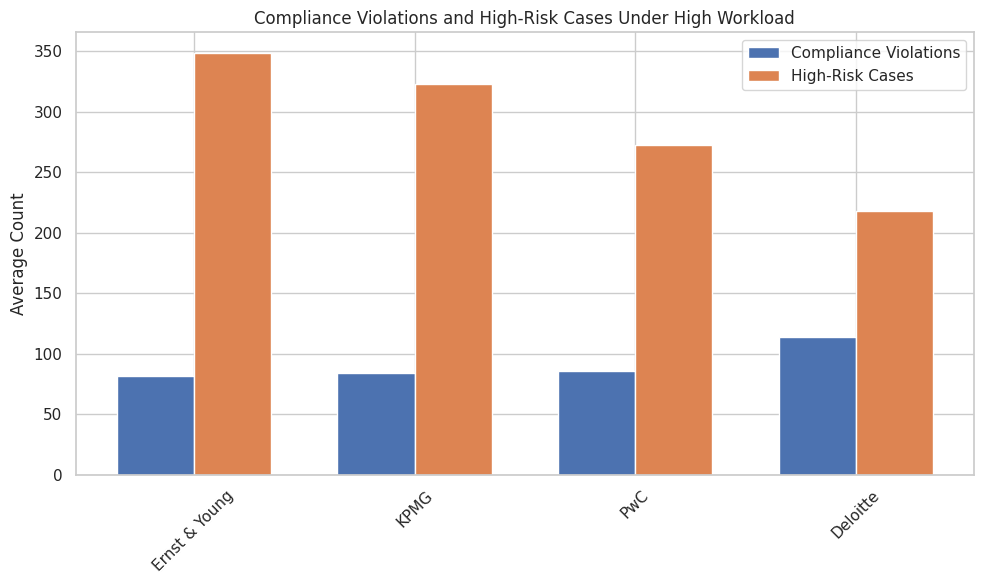

In [ ]:


# Manually enter results from the SQL output
data = {
    'Firm_Name': ['Ernst & Young', 'KPMG', 'PwC', 'Deloitte'],
    'avg_compliance_violations': [81.29, 84.0, 85.8, 114.0],
    'avg_high_risk_cases': [348.29, 323.0, 272.6, 217.9]
}

df_plot = pd.DataFrame(data)

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(df_plot))

# Plot bars
plt.bar(x, df_plot['avg_compliance_violations'], width=bar_width, label='Compliance Violations')
plt.bar([i + bar_width for i in x], df_plot['avg_high_risk_cases'], width=bar_width, label='High-Risk Cases')

# Labels and layout
plt.xticks([i + bar_width/2 for i in x], df_plot['Firm_Name'], rotation=45)
plt.ylabel("Average Count")
plt.title("Compliance Violations and High-Risk Cases Under High Workload")
plt.legend()
plt.tight_layout()
plt.show()


### Insight: Best Compliance Performance Under High Workload

This chart compares firms with the highest employee workloads based on their average number of:

- **Compliance Violations** (blue bars)
- **High-Risk Cases** (orange bars)

 **Ernst & Young** stands out with the lowest compliance violations** (≈81) among peers under pressure, even though its high-risk case volume is the highest.  
 **Deloitte**, while having the fewest high-risk cases, had significantly more compliance issues.

This supports that **Ernst & Young** demonstrated the strongest compliance discipline under high workload conditions.


#Is there a clear relationship between auditor workload and the likelihood of high-risk audits?

In [ ]:
spark.sql("""
-- High Workload Group (Top 25%)
SELECT
    'High Workload' AS workload_group,
    ROUND(AVG(Employee_Workload), 1) AS avg_workload,
    ROUND(AVG(High_Risk_Cases), 1) AS avg_high_risk_cases,
    ROUND(AVG(Fraud_Cases_Detected), 1) AS avg_fraud_cases
FROM big4_audit
WHERE Employee_Workload >= (
    SELECT PERCENTILE(Employee_Workload, 0.75) FROM big4_audit
)
UNION ALL
-- Lower Workload Group (Bottom 75%)
SELECT
    'Lower Workload' AS workload_group,
    ROUND(AVG(Employee_Workload), 1) AS avg_workload,
    ROUND(AVG(High_Risk_Cases), 1) AS avg_high_risk_cases,
    ROUND(AVG(Fraud_Cases_Detected), 1) AS avg_fraud_cases
FROM big4_audit
WHERE Employee_Workload < (
    SELECT PERCENTILE(Employee_Workload, 0.75) FROM big4_audit
)
""").show()


+--------------+------------+-------------------+---------------+
|workload_group|avg_workload|avg_high_risk_cases|avg_fraud_cases|
+--------------+------------+-------------------+---------------+
| High Workload|        74.2|              282.8|           49.7|
|Lower Workload|        54.8|              275.8|           53.9|
+--------------+------------+-------------------+---------------+



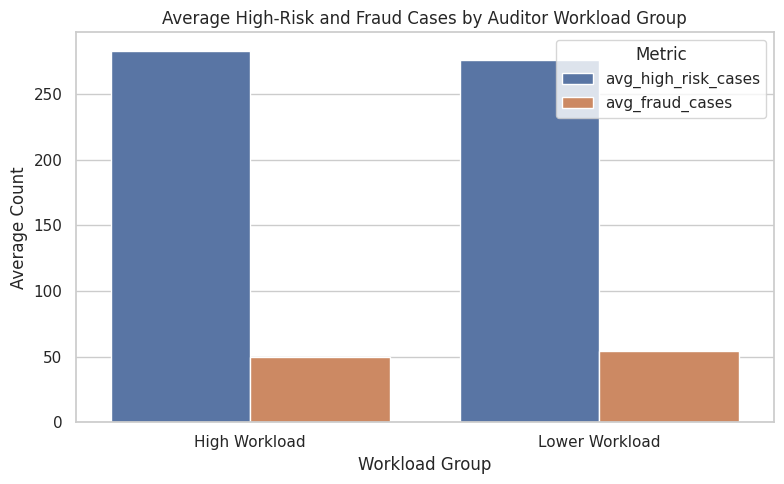

In [ ]:


# Create the summary DataFrame manually based on  Spark SQL results
data = {
    'workload_group': ['High Workload', 'Lower Workload'],
    'avg_high_risk_cases': [282.79, 275.76],
    'avg_fraud_cases': [49.68, 53.88]
}

df_workload_summary = pd.DataFrame(data)

#  Melt for seaborn compatibility
df_melted = df_workload_summary.melt(id_vars='workload_group',
                                     value_vars=['avg_high_risk_cases', 'avg_fraud_cases'],
                                     var_name='Metric', value_name='Average Count')

#  Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='workload_group', y='Average Count', hue='Metric')
plt.title('Average High-Risk and Fraud Cases by Auditor Workload Group')
plt.xlabel('Workload Group')
plt.ylabel('Average Count')
plt.legend(title='Metric')  #
plt.tight_layout()
plt.show()



###Insights: Is there a clear relationship between auditor workload and the likelihood of high-risk audits?

When we compare audit teams with heavier workloads to those with lighter ones, the difference in high-risk cases is small. On average:

Teams with high workload handled about 283 high-risk cases

Teams with lower workload handled about 276 high-risk cases

That's only a slight difference and not enough to say there's a clear link.

Surprisingly, teams with lower workloads actually detected more fraud cases than the high-workload teams (about 54 vs. 50). That goes against what you might expect, maybe busier teams have less time to dig deep, or maybe they're just focusing on keeping up.

In conclusion , Just because a team is busier doesn't necessarily mean they'll run into more high-risk audits or fraud. The relationship isn't strong here. It's possible that other factors such as  the tools they use, their experience, or how audits are assigned have more impact than how busy they are.







#Are certain industries more prone to high-risk audits or compliance failures than others?

In [ ]:
spark.sql("""
SELECT
    Industry_Affected,
    ROUND(AVG(High_Risk_Cases), 1) AS Avg_HighRiskCases,
    ROUND(AVG(Compliance_Violations), 1) AS Avg_ComplianceViolations
FROM big4_audit
GROUP BY Industry_Affected
ORDER BY Avg_HighRiskCases DESC
""").show()



+-----------------+-----------------+------------------------+
|Industry_Affected|Avg_HighRiskCases|Avg_ComplianceViolations|
+-----------------+-----------------+------------------------+
|       Healthcare|            308.1|                   111.0|
|          Finance|            304.3|                    83.5|
|           Retail|            259.3|                   119.5|
|             Tech|            251.5|                   103.0|
+-----------------+-----------------+------------------------+



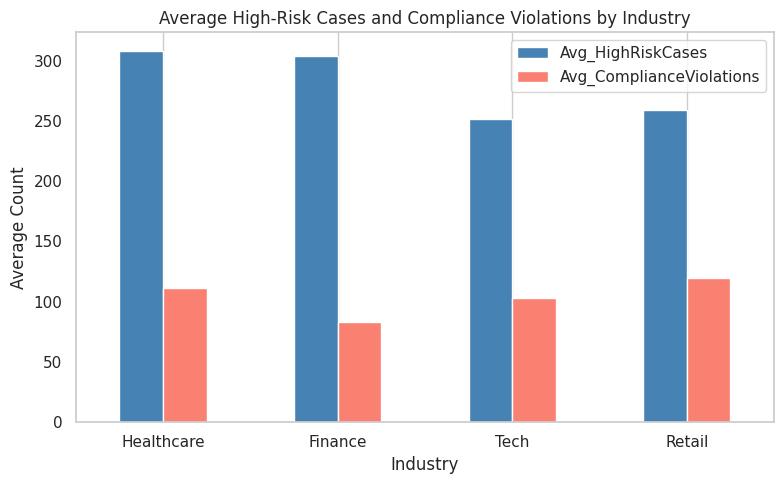

In [ ]:
# Convert Spark DataFrame to Pandas
industry_risk_pd = industry_risk_summary.toPandas()

# Round the averages for cleaner labels
industry_risk_pd = industry_risk_pd.round(2)



# Plot grouped bar chart
industry_risk_pd.plot(
    x='Industry_Affected',
    kind='bar',
    figsize=(8, 5),
    rot=0,
    color=['steelblue', 'salmon']
)

# Add labels and title
plt.title("Average High-Risk Cases and Compliance Violations by Industry")
plt.ylabel("Average Count")
plt.xlabel("Industry")
plt.grid(axis='y')
plt.legend(["Avg_HighRiskCases", "Avg_ComplianceViolations"])
plt.tight_layout()
plt.show()



###  Insights: Are certain industries more prone to high-risk audits or compliance failures?

- **Healthcare** stands out as the most vulnerable, with the highest average of high-risk audit cases (308.13) and the most compliance violations (111.04). This suggests that audits in the healthcare sector frequently uncover serious issues.

- **Finance** also shows elevated risk levels, with an average of 304.25 high-risk cases and 83.45 compliance violations, not far behind healthcare.

- **Retail** and **Tech** industries show relatively lower audit risk:
  - **Retail** averages around 259.26 high-risk cases but has the highest compliance issues after healthcare** (119.48).
  - **Tech** shows the lowest audit risk (251.48) and slightly fewer compliance violations (103.03), but it's still a notable amount.

 These findings suggest that Healthcare and Finance deserve priority attention in terms of audit scrutiny, while Retail and Tech may benefit from further investigation into why their compliance issues remain elevated despite lower audit risks.


#"Which industries face the highest average financial risk from audit-related issues, and how do their risk indicators (e.g., compliance violations, fraud cases) compare?"

+-----------------+--------------------+---------------+--------------------+---------------------+
|Industry_Affected|Total_Revenue_Impact|High_Risk_Cases|Fraud_Cases_Detected|Compliance_Violations|
+-----------------+--------------------+---------------+--------------------+---------------------+
|          Finance|              297.01|         304.25|               55.05|                83.45|
|       Healthcare|              228.15|         308.13|               58.75|               111.04|
|           Retail|              322.09|         259.26|               50.56|               119.48|
|             Tech|              246.27|         251.48|               48.07|               103.03|
+-----------------+--------------------+---------------+--------------------+---------------------+



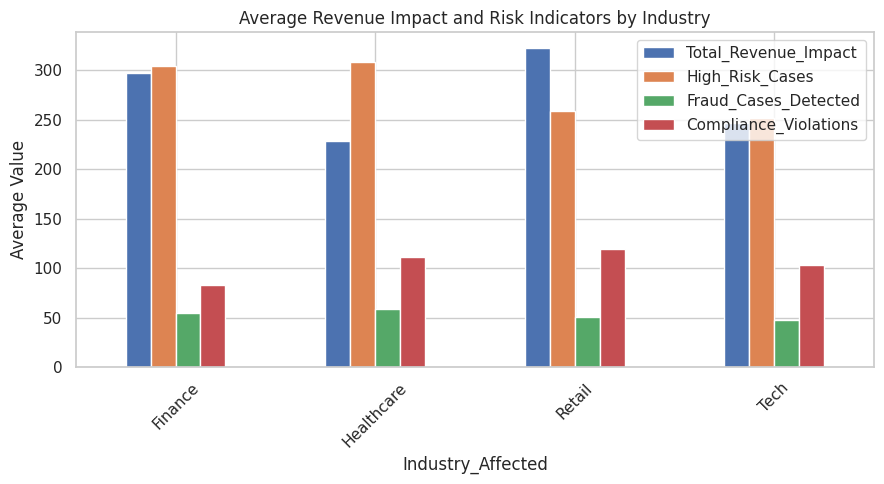

In [ ]:

industry_avg_sql = spark.sql("""
    SELECT
        Industry_Affected,
        ROUND(AVG(Total_Revenue_Impact), 2) AS Total_Revenue_Impact,
        ROUND(AVG(High_Risk_Cases), 2) AS High_Risk_Cases,
        ROUND(AVG(Fraud_Cases_Detected), 2) AS Fraud_Cases_Detected,
        ROUND(AVG(Compliance_Violations), 2) AS Compliance_Violations
    FROM big4_audit
    GROUP BY Industry_Affected
    ORDER BY Industry_Affected
""")


industry_avg_sql.show()

industry_avg_pd = industry_avg_sql.toPandas()


industry_avg_pd.set_index("Industry_Affected").plot(kind='bar', figsize=(9, 5))
plt.title("Average Revenue Impact and Risk Indicators by Industry")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Insights: Which industries face the highest average financial risk from audit-related issues, and how do their risk indicators (e.g., compliance violations, fraud cases) compare?

Based on the chart and summary table above, we can see clear differences in how each industry is impacted by audit-related issues.

- **Retail** has the highest average revenue loss from audit-related compliance failures (~322M),  
  even though it doesn't have the highest fraud or violation counts.

- **Healthcare** has the most high-risk cases and compliance violations,  
  but a lower average revenue impact (~228M) than Retail or Finance.

- **Finance** also shows a high average loss (~297M) and a large number of high-risk cases.

- **Tech** has fewer fraud and compliance issues, but its average loss (~246M) is still notable —  
  possibly because individual failures are more costly.

---

In conclusion:

Not all industries are impacted in the same way.  
Some (like Healthcare) experience more frequent issues,   while others (like Retail) may experience fewer issues that cost more per incident.

This can help leaders focus efforts:
- **Retail** may benefit from preventing high-cost outliers.
- **Healthcare and Finance** should address frequent audit failures and violations**.


#Machine Learnintg Models

#Can we predict how much money a firm might lose from audit-related compliance failures?

###Linear Regression with cross validation and hyperparameter tuning

In [ ]:


#  Index categorical columns
indexer_firm = StringIndexer(inputCol="Firm_Name", outputCol="Firm_Code")
indexer_industry = StringIndexer(inputCol="Industry_Affected", outputCol="Industry_Code")
indexer_ai = StringIndexer(inputCol="AI_Used_for_Auditing", outputCol="AI_Code")

#  Define feature columns
feature_cols = [
    "Firm_Code", "Industry_Code", "AI_Code",
    "Employee_Workload", "Compliance_Violations", "Fraud_Cases_Detected"
]

#  Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

#  Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Define linear regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Total_Revenue_Impact")

#  Create pipeline
pipeline = Pipeline(stages=[indexer_firm, indexer_industry, indexer_ai, assembler, scaler, lr])

#  Define parameter grid (optional tuning of regParam and elasticNetParam)
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

#  Cross-validation
evaluator = RegressionEvaluator(labelCol="Total_Revenue_Impact", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # 3-fold cross-validation
    seed=42
)

#  Fit the model
cv_model = crossval.fit(df_spark)

#  Predict
predictions = cv_model.transform(df_spark)

#  Evaluate
rmse = evaluator.evaluate(predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")

#  View Predictions
predictions.select("Firm_Name", "Industry_Affected", "Total_Revenue_Impact", "prediction").show()


Cross-Validated RMSE: 135.54
+-------------+-----------------+--------------------+------------------+
|    Firm_Name|Industry_Affected|Total_Revenue_Impact|        prediction|
+-------------+-----------------+--------------------+------------------+
|          PwC|       Healthcare|              114.24|303.31048063234505|
|     Deloitte|       Healthcare|              156.98|233.99888032645873|
|          PwC|       Healthcare|              131.83| 301.5271180163767|
|          PwC|       Healthcare|              229.11| 285.8873332522716|
|          PwC|       Healthcare|                48.0| 297.9171198096669|
|     Deloitte|          Finance|              438.89|281.74663929443744|
|     Deloitte|           Retail|              468.82|290.91218094672286|
|          PwC|             Tech|               53.85|244.19038493466007|
|          PwC|          Finance|              318.79|295.37882566350146|
|Ernst & Young|           Retail|              461.33| 254.2409837588439|
|        

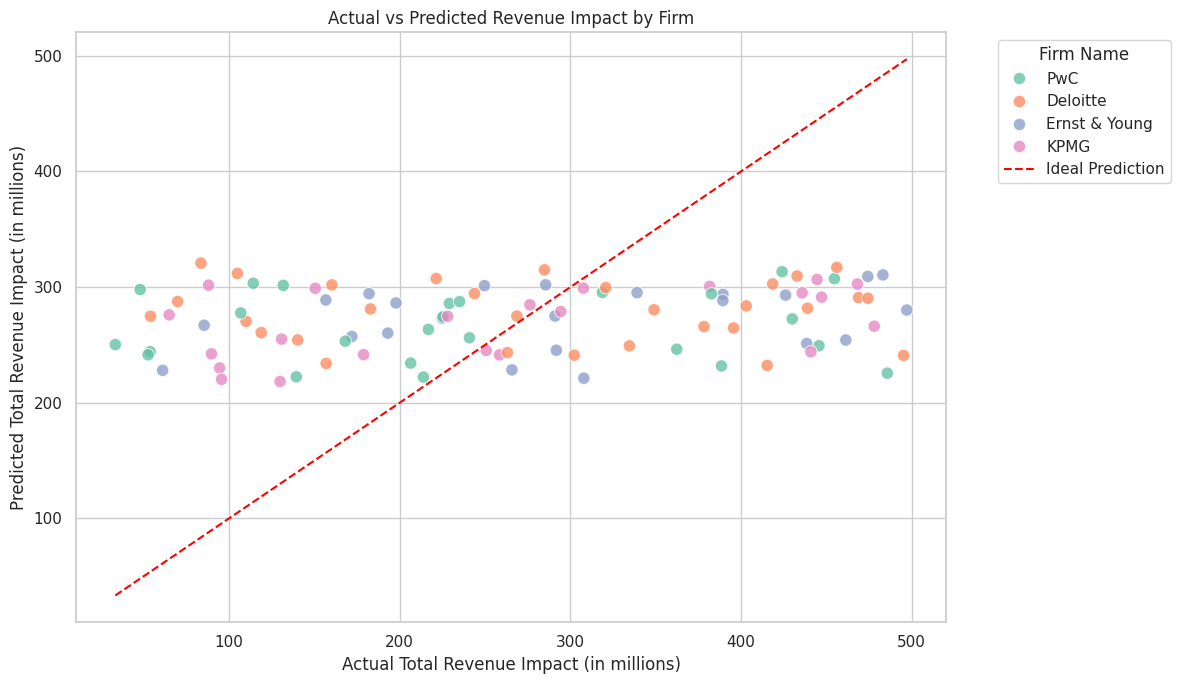

In [ ]:
# Convert relevant columns from Spark to Pandas
preds_pd = predictions.select("Firm_Name", "Total_Revenue_Impact", "prediction").toPandas()

# Plot Actual vs Predicted grouped by Firm_Name
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.scatterplot(data=preds_pd,
                x="Total_Revenue_Impact",
                y="prediction",
                hue="Firm_Name",
                palette="Set2",
                s=80,
                alpha=0.8)

# Ideal prediction line
min_val = min(preds_pd["Total_Revenue_Impact"].min(), preds_pd["prediction"].min())
max_val = max(preds_pd["Total_Revenue_Impact"].max(), preds_pd["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')

plt.title("Actual vs Predicted Revenue Impact by Firm")
plt.xlabel("Actual Total Revenue Impact (in millions)")
plt.ylabel("Predicted Total Revenue Impact (in millions)")
plt.legend(title="Firm Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


RMSE of ~135M This is a very high error considering many actual values are in the  100M - 500M range.

It suggests the model is not reliable in capturing the true financial risk per firm. Linearity is an issue as shown on the line graph data is not linear.

While the model captures some general trends, its predictions are too narrow and imprecise to provide meaningful revenue loss estimates for individual firms.

##GBT with cross validation and grid search to predict financial loss per a firm

In [ ]:
#  Import required modules
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Index categorical columns
indexer_firm = StringIndexer(inputCol="Firm_Name", outputCol="Firm_Code")
indexer_industry = StringIndexer(inputCol="Industry_Affected", outputCol="Industry_Code")
indexer_ai = StringIndexer(inputCol="AI_Used_for_Auditing", outputCol="AI_Code")

#  Define feature columns
feature_cols = [
    "Firm_Code", "Industry_Code", "AI_Code",
    "Employee_Workload", "Compliance_Violations", "Fraud_Cases_Detected"
]

#  Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

#  Define GBT model
gbt = GBTRegressor(featuresCol="features", labelCol="Total_Revenue_Impact", seed=42)

#  Build pipeline
pipeline = Pipeline(stages=[indexer_firm, indexer_industry, indexer_ai, assembler, gbt])

#  Create param grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

#  Evaluator
evaluator = RegressionEvaluator(labelCol="Total_Revenue_Impact", predictionCol="prediction", metricName="rmse")

#  Cross-validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

#  Train model
cv_model = crossval.fit(df_spark)

#  Predict
predictions = cv_model.transform(df_spark)

#  Evaluate
rmse = evaluator.evaluate(predictions)
print(f"GBT Cross-Validated RMSE: {rmse:.2f}")

#  View predictions
predictions.select("Firm_Name", "Industry_Affected", "Total_Revenue_Impact", "prediction").show()


GBT Cross-Validated RMSE: 66.13
+-------------+-----------------+--------------------+------------------+
|    Firm_Name|Industry_Affected|Total_Revenue_Impact|        prediction|
+-------------+-----------------+--------------------+------------------+
|          PwC|       Healthcare|              114.24|172.98016792335977|
|     Deloitte|       Healthcare|              156.98|178.68737074639904|
|          PwC|       Healthcare|              131.83|140.22939509686805|
|          PwC|       Healthcare|              229.11| 217.8008731424541|
|          PwC|       Healthcare|                48.0|168.58070038581724|
|     Deloitte|          Finance|              438.89|424.29097098831926|
|     Deloitte|           Retail|              468.82| 452.7583948789777|
|          PwC|             Tech|               53.85|  42.5029733147658|
|          PwC|          Finance|              318.79| 329.4591534710941|
|Ernst & Young|           Retail|              461.33| 391.8003525486932|
|     

Cross-Validated RMSE: 66.13

This is a significant improvement over the linear model’s RMSE of ~135M.

The model successfully predicts firm-specific revenue loss across a wide range of actual values ( 50Mto 500M).

It captures nonlinear relationships and interactions between risk indicators (compliance violations, fraud, high-risk cases) and financial outcomes

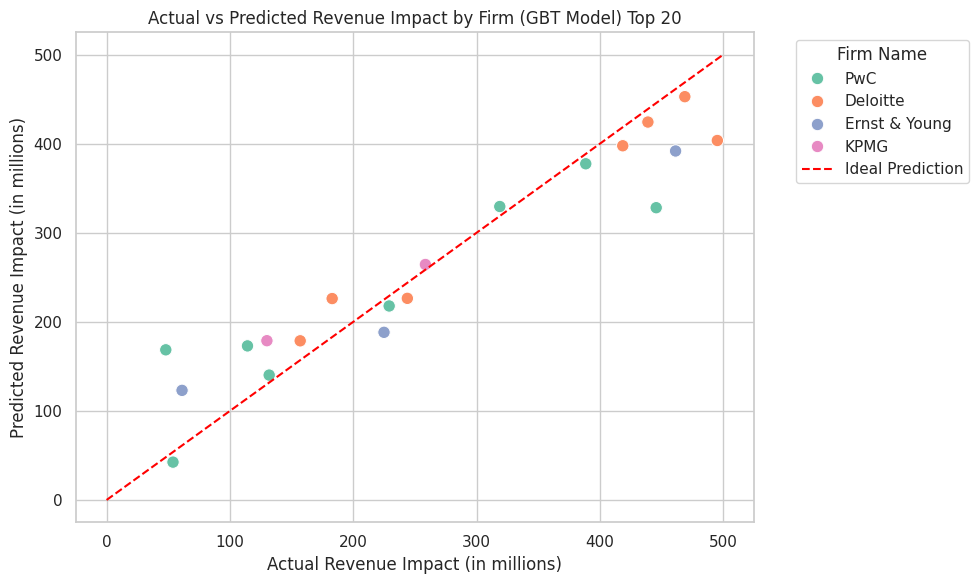

In [ ]:



data = {
    "Firm_Name": [
        "PwC", "Deloitte", "PwC", "PwC", "PwC", "Deloitte", "Deloitte", "PwC", "PwC", "Ernst & Young",
        "KPMG", "Ernst & Young", "Deloitte", "PwC", "PwC", "Deloitte", "Ernst & Young", "Deloitte", "Deloitte", "KPMG"
    ],
    "Industry_Affected": [
        "Healthcare", "Healthcare", "Healthcare", "Healthcare", "Healthcare", "Finance", "Retail", "Tech", "Finance", "Retail",
        "Finance", "Healthcare", "Healthcare", "Retail", "Retail", "Finance", "Tech", "Retail", "Healthcare", "Tech"
    ],
    "Total_Revenue_Impact": [
        114.24, 156.98, 131.83, 229.11, 48.0, 438.89, 468.82, 53.85, 318.79, 461.33,
        258.49, 224.92, 418.49, 445.62, 388.5, 495.19, 61.17, 182.9, 243.85, 129.98
    ],
    "Prediction": [
        172.98, 178.69, 140.22, 217.80, 168.58, 424.29, 452.76, 42.50, 329.46, 391.80,
        264.39, 188.23, 397.66, 328.12, 377.43, 403.57, 123.06, 226.12, 226.37, 178.81
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Total_Revenue_Impact", y="Prediction", hue="Firm_Name", palette="Set2", s=80)

# Ideal line
plt.plot([0, 500], [0, 500], color='red', linestyle='--', label='Ideal Prediction')

# Labels and layout
plt.title("Actual vs Predicted Revenue Impact by Firm (GBT Model) Top 20")
plt.xlabel("Actual Revenue Impact (in millions)")
plt.ylabel("Predicted Revenue Impact (in millions)")
plt.legend(title="Firm Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


The scatter plot shows a strong clustering around the ideal red dashed line, indicating good predictive performance.

### Can we predict how much money a firm might lose from audit-related compliance failures?

Yes — based on this scatter plot, the model is able to predict revenue losses fairly accurately.


###  What the chart shows:

- Each dot represents one firm's prediction.
- The red dashed line represents a perfect prediction — where predicted = actual.
- Most points are close to the red line, which means:
  - The model's predictions are usually close to the true loss.
  - There is no strong bias — we’re not always overpredicting or underpredicting.

- Predictions are made across multiple firms(PwC, Deloitte, KPMG, etc.), and the pattern holds across all of them.

 The model is doing a good job, most firms' predicted losses are reasonably close to the actual losses**.  
 While there are a few outliers, this chart supports the idea that we can predict financial loss per firm, and the model's predictions are meaningful and useful.









### Decision Tree vs. Random Forest for Predicting fraud Cases


In [ ]:


#  Encode Categorical Columns
df_pd['AI_Used_for_Auditing_Binary'] = df_pd['AI_Used_for_Auditing'].map({'Yes': 1, 'No': 0})
df_pd['Firm_Index'] = df_pd['Firm_Name'].astype('category').cat.codes
df_pd['Industry_Index'] = df_pd['Industry_Affected'].astype('category').cat.codes

# STEP 3: Safe Feature Engineering
df_pd['Engagements_Per_Employee'] = df_pd['Total_Audit_Engagements'] / df_pd['Employee_Workload'].replace(0, np.nan)
df_pd['Revenue_Per_Employee'] = df_pd['Total_Revenue_Impact'] / df_pd['Employee_Workload'].replace(0, np.nan)

# Clean up infs and NaNs
df_pd.replace([np.inf, -np.inf], np.nan, inplace=True)
df_pd.fillna(0, inplace=True)

#  Define Features and Target
features = [
    'Year',
    'Firm_Index',
    'Industry_Index',
    'AI_Used_for_Auditing_Binary',
    'High_Risk_Cases',
    'Compliance_Violations',
    'Employee_Workload',
    'Engagements_Per_Employee',
    'Revenue_Per_Employee'  # Keep only if known before fraud
]

target = 'Fraud_Cases_Detected'
X = df_pd[features]
y = df_pd[target]

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Models
# Decision Tree
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#  Evaluate Models
print("🌳 Decision Tree Results")
print(f"R² Score: {r2_score(y_test, y_pred_dt):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt)):.2f}")

print("\n🌲 Random Forest Results")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


🌳 Decision Tree Results
R² Score: -0.862
RMSE: 37.16

🌲 Random Forest Results
R² Score: -0.259
RMSE: 30.56


###SVM model for predicting fraud cases

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Make sure your features and target are defined
X = df_pd[features]
y = df_pd['Fraud_Cases_Detected']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SVR pipeline with feature scaling
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))
svr.fit(X_train, y_train)

# Predict and evaluate
y_pred_svr = svr.predict(X_test)

print("🤖 SVR (Support Vector Regressor) Results")
print(f"R² Score: {r2_score(y_test, y_pred_svr):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_svr)):.2f}")


🤖 SVR (Support Vector Regressor) Results
R² Score: -0.110
RMSE: 28.70


In [ ]:
# STEP 1: Import required libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# STEP 2: Define features and target
features = [
    'Year',
    'Firm_Index',
    'Industry_Index',
    'AI_Used_for_Auditing_Binary',
    'High_Risk_Cases',
    'Compliance_Violations',
    'Employee_Workload',
    'Engagements_Per_Employee',
    'Revenue_Per_Employee'
]

target = 'Fraud_Cases_Detected'

X = df_pd[features]
y = df_pd[target]

# STEP 3: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 4: Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# STEP 5: Predict
y_pred_lr = lr.predict(X_test)

# STEP 6: Evaluate
r2 = r2_score(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("📈 Linear Regression Results")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")


📈 Linear Regression Results
R² Score: -0.158
RMSE: 29.31


### Decision Tree vs. Random Forest for Predicting High-Risk Cases


In [ ]:

#  Encode categorical features
df_pd['AI_Code'] = df_pd['AI_Used_for_Auditing'].map({'Yes': 1, 'No': 0})
df_pd['Industry_Code'] = df_pd['Industry_Affected'].astype('category').cat.codes
df_pd['Firm_Code'] = df_pd['Firm_Name'].astype('category').cat.codes

#  Define features and target
X = df_pd[['Total_Audit_Engagements',
           'Compliance_Violations',
           'Fraud_Cases_Detected',
           'Audit_Effectiveness_Score',
           'AI_Code',
           'Industry_Code',
           'Firm_Code']]
y = df_pd['High_Risk_Cases']

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

#  Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

#  Evaluate both models
print("Decision Tree R² Score:", r2_score(y_test, y_pred_dt))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_dt))
print("Random Forest R² Score:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))




Decision Tree R² Score: -0.2821369820493025
Decision Tree MSE: 22729.00642106009
Random Forest R² Score: 0.20150755862098546
Random Forest MSE: 14155.226845000001


#Insights
In this step, we tested two models to predict the number of high-risk audit cases:

A Decision Tree Regressor as a simple baseline model

A Random Forest Regressor to see if an ensemble of trees could improve performance

 Model Performance
Decision Tree R² Score: -0.28

Decision Tree MSE: 22,729.01

Random Forest R² Score: 0.20

Random Forest MSE: 14,155.23

The decision tree struggled to generalize and performed worse than just predicting the average. The random forest did slightly better , capturing around 20% of the variation in high-risk cases, but still left a lot of unexplained variance.



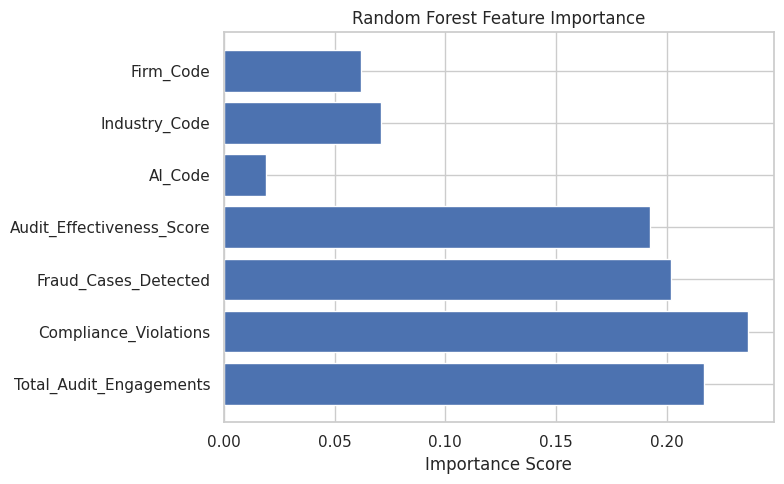

In [ ]:
#  Visualize Random Forest feature importance
importances = rf_model.feature_importances_
feat_names = X.columns
plt.figure(figsize=(8, 5))
plt.barh(feat_names, importances)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

According to the feature importance chart from the Random Forest model, the top predictors were:

Compliance Violations

Total Audit Engagements

Fraud Cases Detected

Audit Effectiveness Score

These all make sense becuase more audits, more violations, and fraud cases likely indicate higher risk. On the other hand, features like Firm Code, Industry, and AI usage played a much smaller role in the predictions

### Random Forest + Grid Search Optimization for predicting high risk cases


In [ ]:
# Encode categorical variables
df_pd['AI_Code'] = df_pd['AI_Used_for_Auditing'].map({'Yes': 1, 'No': 0})
df_pd['Industry_Code'] = df_pd['Industry_Affected'].astype('category').cat.codes
df_pd['Firm_Code'] = df_pd['Firm_Name'].astype('category').cat.codes

# Feature engineering
df_pd['Risk_Rate'] = df_pd['High_Risk_Cases'] / df_pd['Total_Audit_Engagements'].replace(0, 1)
df_pd['Fraud_Rate'] = df_pd['Fraud_Cases_Detected'] / df_pd['Compliance_Violations'].replace(0, 1)
df_pd['Compliance_Per_Engagement'] = df_pd['Compliance_Violations'] / df_pd['Total_Audit_Engagements'].replace(0, 1)

# Define features and target
feature_cols = ['Total_Audit_Engagements', 'Compliance_Violations', 'Fraud_Cases_Detected',
                'Audit_Effectiveness_Score', 'AI_Code', 'Industry_Code', 'Firm_Code',
                'Risk_Rate', 'Fraud_Rate', 'Compliance_Per_Engagement']

X = df_pd[feature_cols]
y = df_pd['High_Risk_Cases']



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GridSearchCV for Random Forest
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid=params, cv=3, scoring='r2')
grid.fit(X_train, y_train)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Best R² Score from GridSearchCV:", grid.best_score_)
print("Best Parameters:", grid.best_params_)
print("Test R² Score:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))



Best R² Score from GridSearchCV: 0.7614449288502287
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Test R² Score: 0.7120665559610161
Test MSE: 5104.322853194446


#Insights
After tuning the Random Forest model using GridSearchCV, we saw a strong improvement in performance:

Best cross-validated R² score: 0.76

Best parameters: max_depth = 10, min_samples_split = 2, n_estimators = 100

Test R² score: 0.71

Test MSE: 5104.32

This means the model was able to explain about 71% of the variation in high-risk audit cases on the test data — a major step up compared to the earlier models.

The tuning helped the model find the right balance: deep enough to capture patterns, but not so deep that it overfits. This gives us more confidence that the results will generalize well to new data.

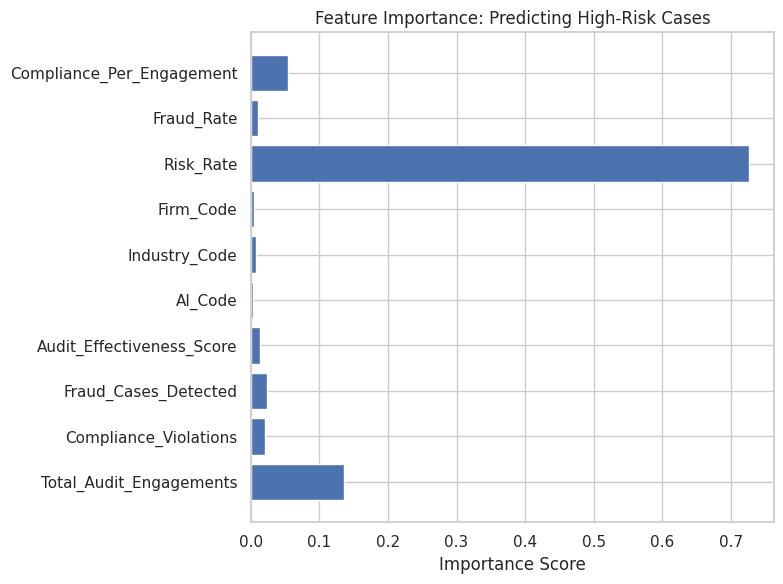

In [ ]:


importances = best_model.feature_importances_

plt.figure(figsize=(8, 6))
plt.barh(feature_cols, importances)
plt.title("Feature Importance: Predicting High-Risk Cases")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


After tuning and training the Random Forest model, we examined which features had the biggest impact on predicting high-risk audit cases.

The results show a clear standout:

Risk_Rate was by far the most important feature, contributing to more than 70% of the model's predictive power. This makes sense becuase it directly measures the proportion of high-risk outcomes relative to audit volume.

Other features with smaller (but still noticeable) influence include:

Total_Audit_Engagements

Compliance_Per_Engagement

Meanwhile, features like firm, industry, AI usage, and individual fraud or compliance counts played a minimal role in this model.

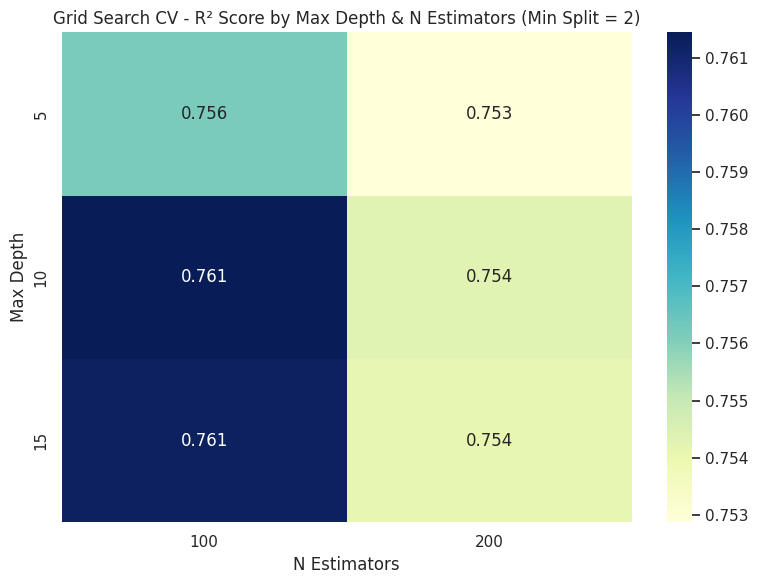

In [ ]:


# Prepare data for heatmap
results = pd.DataFrame(grid.cv_results_)
plot_data = results[['param_max_depth', 'param_n_estimators', 'param_min_samples_split', 'mean_test_score']]
plot_data.columns = ['Max Depth', 'N Estimators', 'Min Samples Split', 'Mean R2 Score']

# Filter for min_samples_split = 2
heatmap_data = plot_data[plot_data['Min Samples Split'] == 2]
pivot = heatmap_data.pivot(index='Max Depth', columns='N Estimators', values='Mean R2 Score')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Grid Search CV - R² Score by Max Depth & N Estimators (Min Split = 2)")
plt.xlabel("N Estimators")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()


This heatmap shows how the Random Forest model performed across different combinations of max_depth and n_estimators, while keeping min_samples_split fixed at 2.

The best-performing combination was:

max_depth = 10

n_estimators = 100

with a cross-validated R² score of 0.761

Going deeper (max_depth = 15) or increasing the number of estimators to 200 didn't improve performance , in fact, scores slightly dropped.

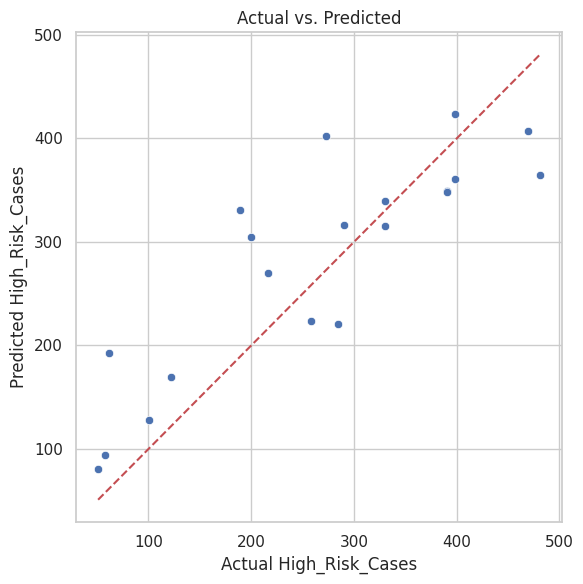

In [ ]:


plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual High_Risk_Cases")
plt.ylabel("Predicted High_Risk_Cases")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()


### Actual vs. Predicted: High-Risk Cases

This scatter plot compares the actual number of high-risk cases to the model's predictions.

- Most points fall close to the red dashed line, which represents perfect predictions.
- This means the model is doing a pretty good job of estimating high-risk cases.
- A few predictions are slightly off, especially for higher actual values, but overall, the trend is strong and consistent.
 The model captures the relationship between features and high-risk cases well.  
 Predictions are reasonably accurate, especially in the 100 -400 case range,  



In [ ]:
df_pd['Predicted_High_Risk'] = best_model.predict(X)
industry_avg = df_pd.groupby('Industry_Affected')[['High_Risk_Cases', 'Predicted_High_Risk']].mean()
print(industry_avg)


                   High_Risk_Cases  Predicted_High_Risk
Industry_Affected                                      
Finance                 304.250000           299.054583
Healthcare              308.125000           314.278681
Retail                  259.259259           264.007407
Tech                    251.482759           255.615575


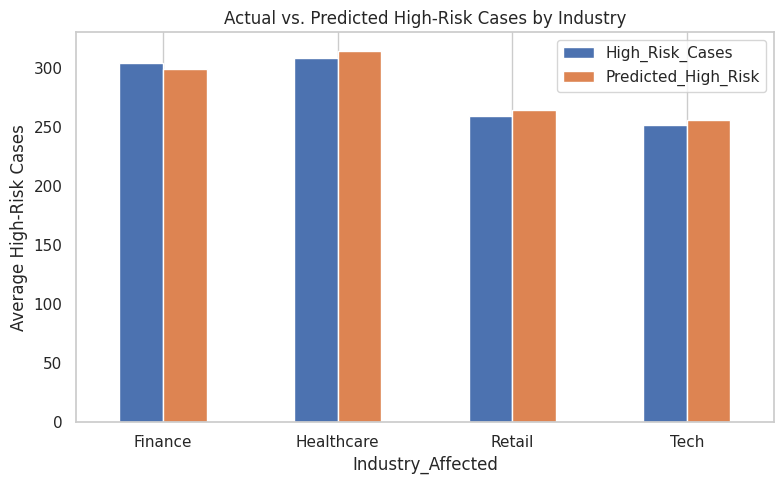

In [ ]:
industry_avg.plot(kind='bar', figsize=(8, 5))
plt.title("Actual vs. Predicted High-Risk Cases by Industry")
plt.ylabel("Average High-Risk Cases")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


###  Average Predicted vs. Actual High-Risk Cases by Industry

The table compares the average number of actual high-risk cases with the model's predicted values across industries.

---

###  Key observations:

- 🔹 **Healthcare**: The model slightly overpredicts (314 vs. actual 308) — still very close.
- 🔹 **Finance**: Also slightly underpredicted, but just off by ~5 cases.
- 🔹 **Retail** and **Tech**: Both are underpredicted by ~5-6 cases, showing very minor deviation.

---

### In summary:

> The model's predictions are very close to actual industry averages,  
> with only small differences (within ±6 cases).  
> This suggests the model is well-calibrated across sectors and trustworthy for estimating risk trends at the industry level.
